# Выпускной проект Промышленность

**Заказчик** этого проекта — металлургический комбинат «Стальная птица».<br><br>
**Цель проекта:**
- построить модель, которая будет предсказывать температуру сплава для имитации технологического процесса и в дальнейшем уменьшения электропотребления на этапе обработки стали.

**Описание данных:**<br>
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:<br>
 - steel.data_arc — данные об электродах;
 - steel.data_bulk — данные об объёме сыпучих материалов;
 - steel.data_bulk_time — данные о времени подачи сыпучих материалов;
 - steel.data_gas — данные о продувке сплава газом;
 - steel.data_temp — данные об измерениях температуры;
 - steel.data_wire — данные об объёме проволочных материалов;
 - steel.data_wire_time — данные о времени подачи проволочных материалов.

**План работ:**<br>
- загрузить данные
- провести исследовательский анализ и предобработать данные: преобразовать типы, заполнить пропуски, обработать аномалии.
- объединить таблицы, выбрать признаки и сгенерировать новые.
- создать модель для прогноза температуры сплава.
- найти лучшую модель и проверить ее в работе, использовав метрику MAE.
- протестировать выбранную модель и проанализировать важность признаков.

## Подключение к базе и загрузка данных

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import catboost as cb

import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import loguniform

from warnings import simplefilter
import torch
import torch.nn as nn
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
from torch.utils.data import DataLoader, TensorDataset
from sklearn.dummy import DummyRegressor

In [3]:
pd.set_option('chained_assignment', None)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-05-01 09:04:42--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.14’

ds-plus-final.db.14 100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-05-01 09:04:42 (47.6 MB/s) - ‘ds-plus-final.db.14’ saved [3588096/3588096]



In [5]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [6]:
query_arc = '''
SELECT *
FROM data_arc
'''

In [7]:
query_bulk = '''
SELECT *
FROM data_bulk
'''

In [8]:
query_bulk_time = '''
SELECT *
FROM data_bulk_time
'''

In [9]:
query_gas = '''
SELECT *
FROM data_gas
'''

In [10]:
query_temp = '''
SELECT *
FROM data_temp
'''

In [11]:
query_wire = '''
SELECT *
FROM data_wire
'''

In [12]:
query_wire_time = '''
SELECT *
FROM data_wire_time
'''

In [13]:
arc_df = pd.read_sql_query(query_arc, con = engine)
bulk_df = pd.read_sql_query(query_bulk, con = engine)
bulk_time_df = pd.read_sql_query(query_bulk_time, con = engine)
gas_df = pd.read_sql_query(query_gas, con = engine)
temp_df = pd.read_sql_query(query_temp, con = engine)
wire_df = pd.read_sql_query(query_wire, con = engine)
wire_time_df = pd.read_sql_query(query_wire_time, con = engine)

In [14]:
arc_df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [15]:
bulk_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


In [16]:
bulk_time_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [17]:
gas_df.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
temp_df.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [19]:
wire_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [20]:
wire_time_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


Настроили подключение, загрузили данные и посмотрели, что в таблицах данные есть и соответсвуют описанию задачи.

## Исследовательский анализ и предобработка данных

In [21]:
dataframes = [arc_df, bulk_df, bulk_time_df, gas_df, temp_df, wire_df, wire_time_df]
names = ['arc_df', 'bulk_df', 'bulk_time_df', 'gas_df', 'temp_df', 'wire_df', 'wire_time_df']
# Создаем сводную таблицу
summary = pd.DataFrame({
    'DataFrame': names,
    'Количество строк': [len(df) for df in dataframes],
    'Количество столбцов': [df.shape[1] for df in dataframes]
})

# Красиво выводим
display(summary.style.background_gradient(cmap='Blues').set_caption("Статистика DataFrame"))

,DataFrame,Количество строк,Количество столбцов
0,arc_df,14876,5
1,bulk_df,3129,16
2,bulk_time_df,3129,16
3,gas_df,3239,2
4,temp_df,18092,3
5,wire_df,3081,10
6,wire_time_df,3081,10


Подключились к базе. Указанные 7 таблиц в базе есть, а именно:
 - steel.data_arc — данные об электродах;
 - steel.data_bulk — данные об объёме сыпучих материалов;
 - steel.data_bulk_time — данные о времени подачи сыпучих материалов;
 - steel.data_gas — данные о продувке сплава газом;
 - steel.data_temp — данные об измерениях температуры;
 - steel.data_wire — данные об объёме проволочных материалов;
 - steel.data_wire_time — данные о времени подачи проволочных материалов.
 
Во всех таблицах есть данные, количество строк в таблицах различается. Количество таблиц соответсвует условиям задачи.

### Исследовательский анализ таблицы data_arc

In [22]:
arc_df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [23]:
arc_df.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [24]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [25]:
#Проверка на пропуски в данных
arc_df.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [26]:
# Проверка на явные дубликаты
arc_df.duplicated().sum()

0

In [27]:
# Проверка на явные дубликаты
arc_df['key'].duplicated().sum()

11662

В таблице arc_df 14876 строк. Каждому ключу key (номеру партии) соответствуют несколько строк, т.к. проводилось несколько этапов нагрева стали.<br>
Пропусков в данных не наблюдаем.

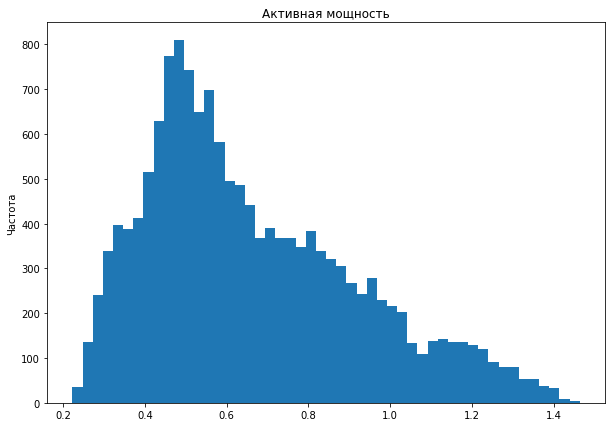

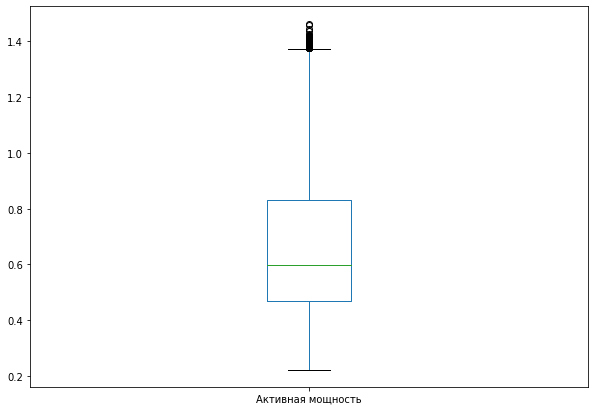

In [28]:
arc_df.plot(y='Активная мощность',title='Активная мощность', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
arc_df.plot(y='Активная мощность', kind='box' , figsize = (10,7), legend = False);

Наблюдаем некоторые выбросы в распределении Активной мощности, но они не являются аномальными.

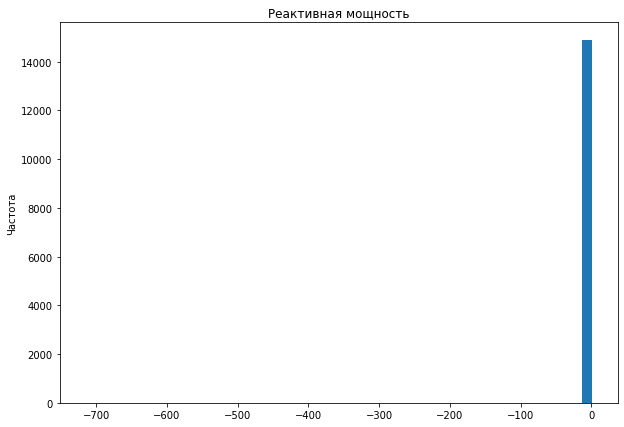

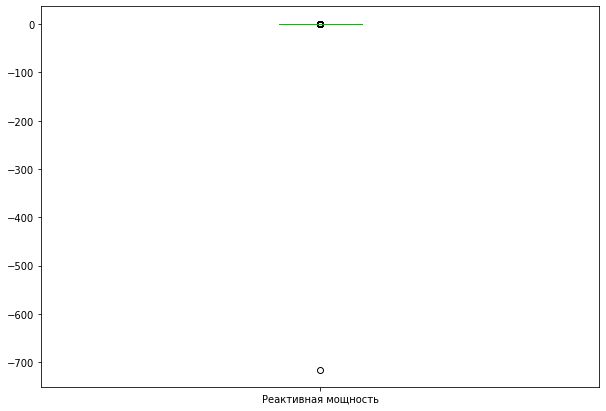

In [29]:
arc_df.plot(y='Реактивная мощность',title='Реактивная мощность', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
arc_df.plot(y='Реактивная мощность', kind='box' , figsize = (10,7), legend = False);

В значениях реактивной мощности видим отрицательное значение. Рассмотрим его подробнее и заменим медианным значением.

In [30]:
arc_df[arc_df['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [31]:
arc_df[arc_df['key'].isin(arc_df[arc_df['Реактивная мощность'] < 0]['key'])]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [32]:
positive_mask = arc_df['Реактивная мощность'] > 0
arc_df['Реактивная мощность'] = np.where(
    arc_df['Реактивная мощность'] < 0,
    arc_df['key'].map(arc_df[positive_mask].groupby('key')['Реактивная мощность'].median()),
    arc_df['Реактивная мощность']
)

In [33]:
arc_df[arc_df['key']==2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.411498
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [34]:
arc_df.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.487110
std,934.571502,0.258885,0.197607
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337192
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [35]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


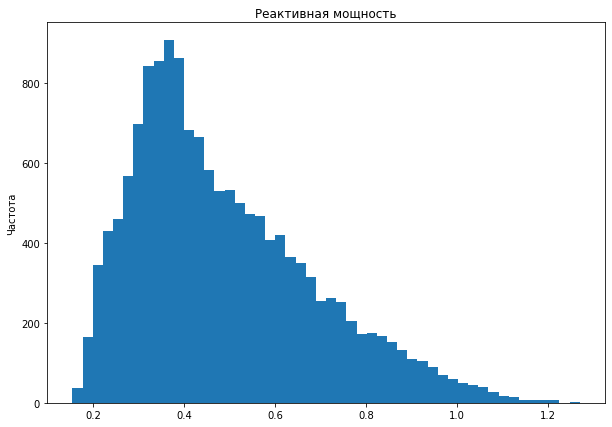

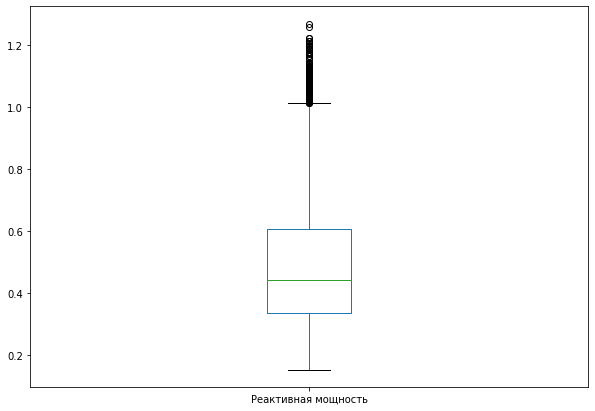

In [36]:
arc_df.plot(y='Реактивная мощность',title='Реактивная мощность', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
arc_df.plot(y='Реактивная мощность', kind='box' , figsize = (10,7), legend = False);

Теперь распределение реактивной мощности ближе к нормальному, но скошено вправо.

Заменим тип данных у временных признаков на datetime и посмотрим минимальные-максимальные значения для выявления аномалий.

In [37]:
arc_df['Начало нагрева дугой'] = pd.to_datetime(arc_df['Начало нагрева дугой'] )

In [38]:
arc_df['Конец нагрева дугой'] = pd.to_datetime(arc_df['Конец нагрева дугой'] )

In [39]:
arc_df['Начало нагрева дугой'].min()

Timestamp('2019-05-03 11:02:14')

In [40]:
arc_df['Начало нагрева дугой'].max()

Timestamp('2019-09-06 17:24:54')

In [41]:
arc_df['Конец нагрева дугой'].min()

Timestamp('2019-05-03 11:06:02')

In [42]:
arc_df['Конец нагрева дугой'].max()

Timestamp('2019-09-06 17:26:15')

Минимальные и максимальные значения указывают на временной промежуток с мая по сентябрь 2019 года. Аномалий не выявлено. <br>
Оценим длительность нагрева - посчитаем длительность в секундах.

In [43]:
arc_df['Длительность нагрева'] = (arc_df['Конец нагрева дугой'] - arc_df['Начало нагрева дугой']).dt.total_seconds()

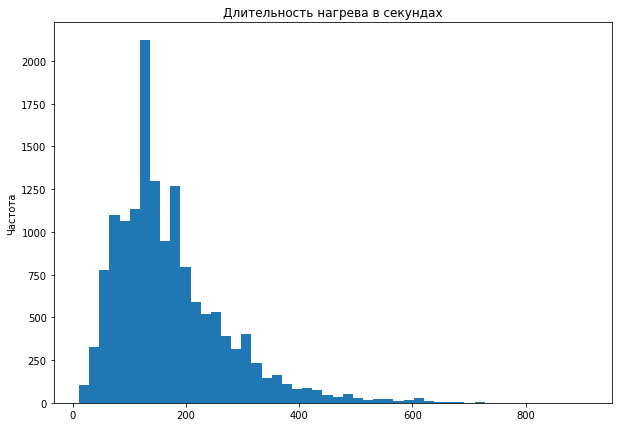

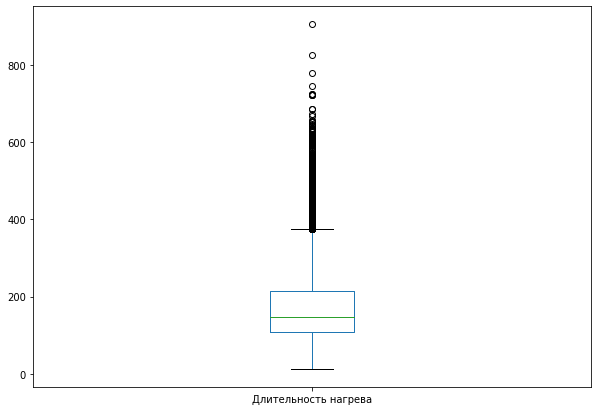

In [44]:
arc_df.plot(y='Длительность нагрева',title='Длительность нагрева в секундах', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
arc_df.plot(y='Длительность нагрева', kind='box' , figsize = (10,7), legend = False);

Длительность нагрева стали на одном этапе, как правило, составляет не более 800 секунд (т.е. 13 минут)

In [45]:
arc_df['Общая мощность'] = np.sqrt(arc_df['Активная мощность']**2 + arc_df['Реактивная мощность']**2)

In [46]:
arc_df['Соотношение активной и реактивной мощности'] = arc_df['Активная мощность']/arc_df['Реактивная мощность']

In [47]:
arc_df.head(50)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Общая мощность,Соотношение активной и реактивной мощности
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,1.444382
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,1.603680
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,1.348123
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,1.364539
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,1.347126
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239,1.729622
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731,1.273142
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064,1.464645
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315,1.449396
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863,1.342109


In [48]:
arc_df['key_count'] = arc_df.groupby('key')['key'].transform('count')


In [49]:
arc_df.head(50)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Общая мощность,Соотношение активной и реактивной мощности,key_count
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,1.444382,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,1.603680,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,1.348123,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,1.364539,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,1.347126,5
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239,1.729622,4
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731,1.273142,4
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064,1.464645,4
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315,1.449396,4
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863,1.342109,5


In [50]:
arc_df.describe()

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Общая мощность,Соотношение активной и реактивной мощности,key_count
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.487110,171.670946,0.823384,1.373523,5.187416
std,934.571502,0.258885,0.197607,98.186803,0.323459,0.130945,1.749516
min,1.000000,0.223120,0.153777,11.000000,0.275718,1.001742,1.000000
25%,806.000000,0.467115,0.337192,107.000000,0.578847,1.280145,4.000000
50%,1617.000000,0.599587,0.441639,147.000000,0.746591,1.379778,5.000000
75%,2429.000000,0.830070,0.608201,214.000000,1.030390,1.471221,6.000000
max,3241.000000,1.463773,1.270284,907.000000,1.898158,1.857442,16.000000


Добавили показатели Общая мощность и Соотношение активной и реактивной мощности.

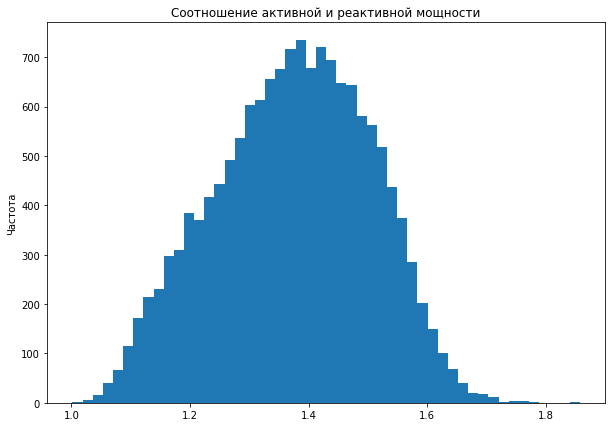

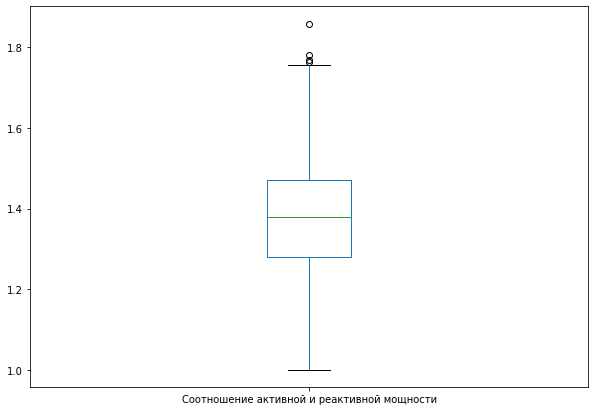

In [51]:
arc_df.plot(y='Соотношение активной и реактивной мощности',title='Соотношение активной и реактивной мощности', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
arc_df.plot(y='Соотношение активной и реактивной мощности', kind='box' , figsize = (10,7), legend = False);

Распределение показателя Соотношение активной и реактивной мощности близко к нормальному.

In [52]:
arc_df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Общая мощность,Соотношение активной и реактивной мощности,key_count
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,1.444382,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,1.603680,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,1.348123,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,1.364539,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,1.347126,5


In [53]:
arc_df_total = arc_df.groupby('key').agg(
    total_active_power=('Активная мощность', 'sum'),  # Суммарная мощность
    total_reactive_power=('Реактивная мощность', 'sum'),
    total_heating_time=('Длительность нагрева', 'sum'),
    total_power=('Общая мощность', 'mean'),
    total_active_reactive=('Соотношение активной и реактивной мощности', 'mean'),
    total_key_count=('key_count', 'max')  # Количество итераций
).reset_index()


In [54]:
arc_df_total.head()

,key,total_active_power,total_reactive_power,total_heating_time,total_power,total_active_reactive,total_key_count
0,1,3.036730,2.142821,1098.0,0.743747,1.421570,5
1,2,2.139408,1.453357,811.0,0.647087,1.479201,4
2,3,4.063641,2.937457,655.0,1.003845,1.396069,5
3,4,2.706489,2.056992,741.0,0.850010,1.307446,4
4,5,2.252950,1.687991,869.0,0.704245,1.328894,4


На финальном этапе сделали агрегацию по всем показателям по ключу key - номер партии.<br>
Получили таблицу arc_df_total, где содержится 3213 строк.

### Исследовательский анализ таблицы data_bulk

In [55]:
bulk_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


In [56]:
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


В таблице data_bulk всего 15 признаков. Видим, что типы данных у признаков, начиная с Bulk 5, не соответствуеют ожидаемым - float. Заменим у них тип на float.

In [57]:
# Список из 15 признаков (замените на ваши названия столбцов)
bulk_features = [
    'Bulk 1',
    'Bulk 2',
    'Bulk 3',
    'Bulk 4',
    'Bulk 5',
    'Bulk 6',
    'Bulk 7',
    'Bulk 8',
    'Bulk 9',
    'Bulk 10',
    'Bulk 11',
    'Bulk 12',
    'Bulk 13',
    'Bulk 14',
    'Bulk 15'
]

In [58]:
for feature in bulk_features:
    bulk_df[feature] = bulk_df[feature].astype(float)

In [59]:
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [60]:
#Проверка на пропуски в данных
bulk_df.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

В данных много пропусков - случаи, когда материал на данном этапе не добавляли в партию. В таком случае мы можем заменить пропуски на нули.

In [61]:
bulk_df = bulk_df.fillna(0)

Построим гистограмму и boxplot для каждого признака - объема подаваемого материала на каждом этапе

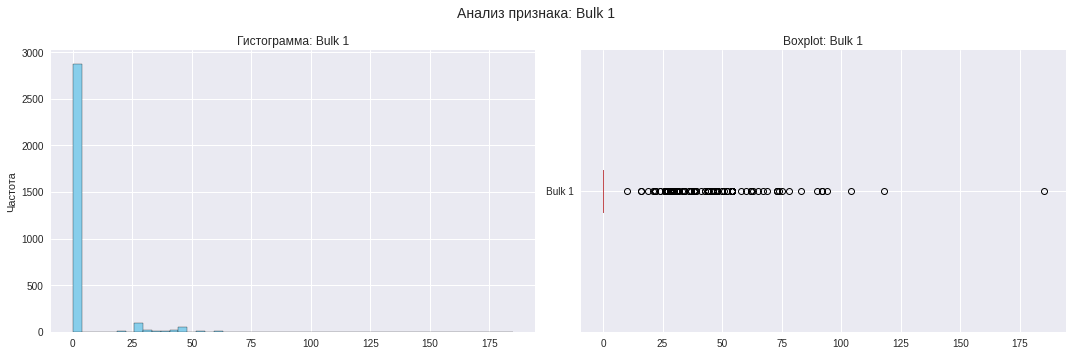

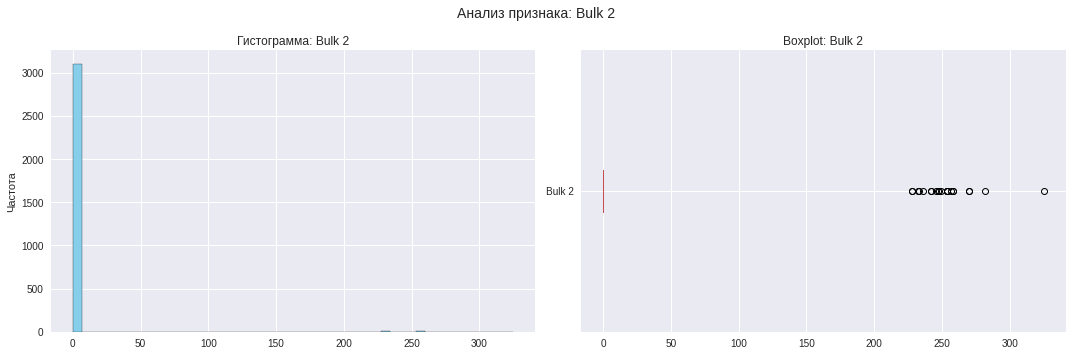

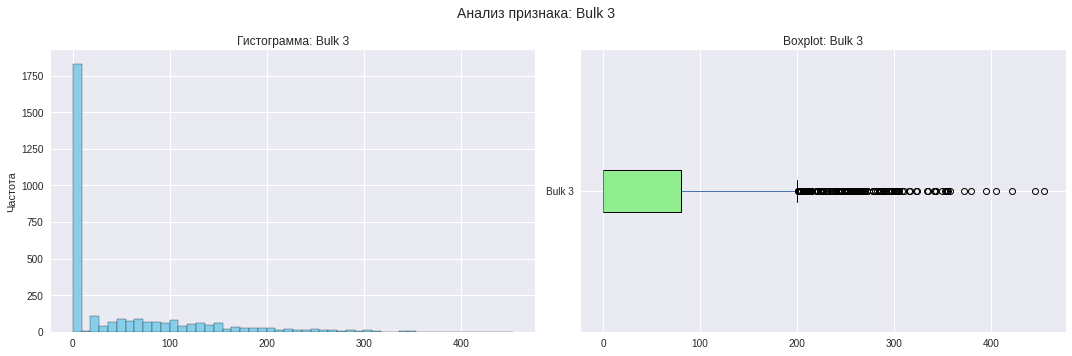

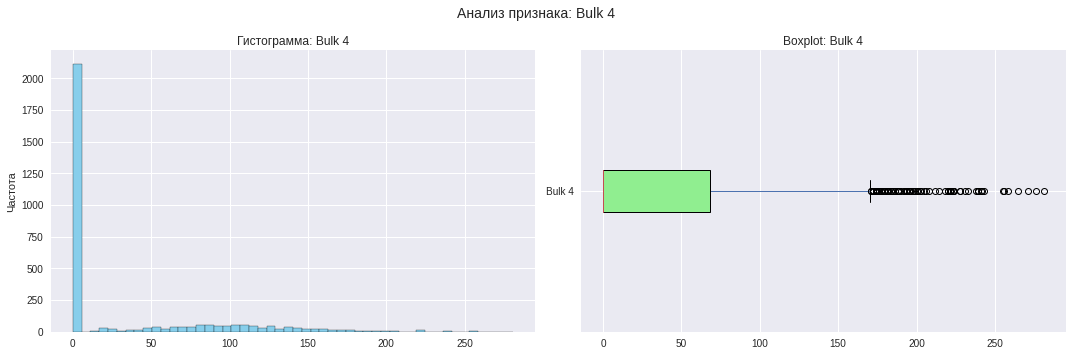

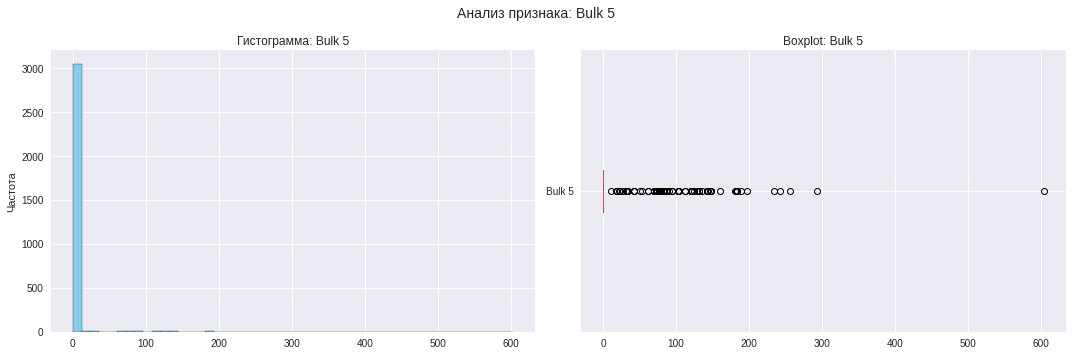

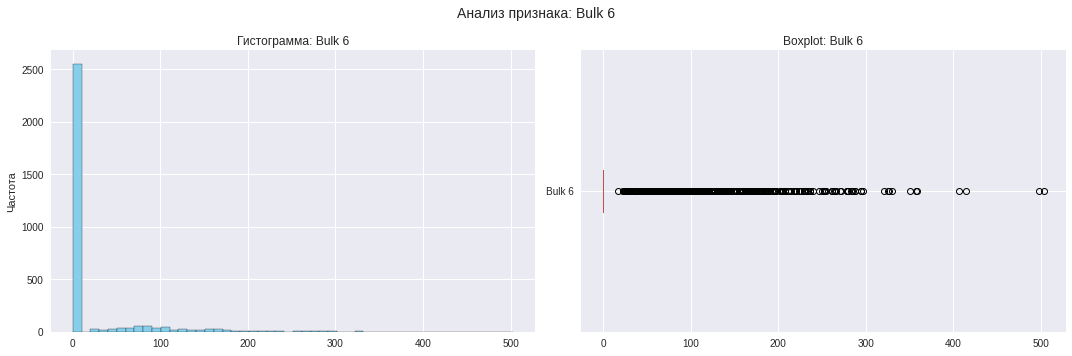

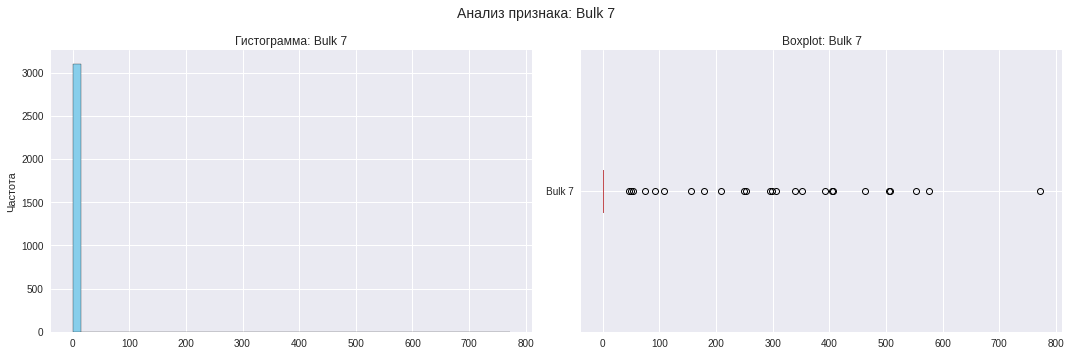

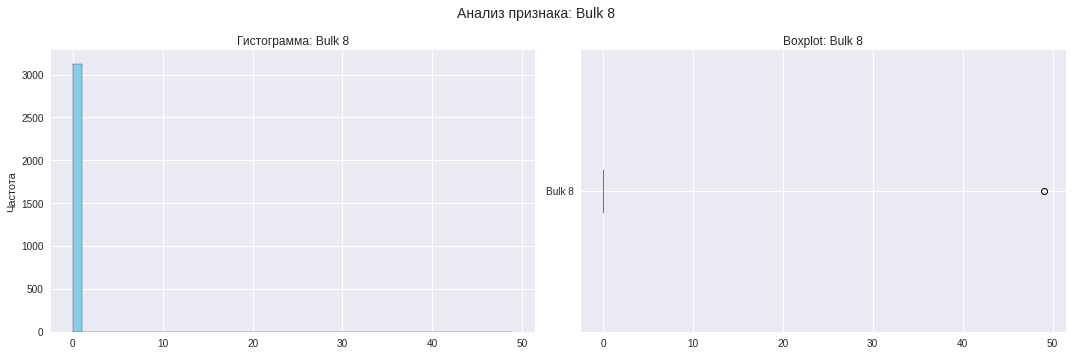

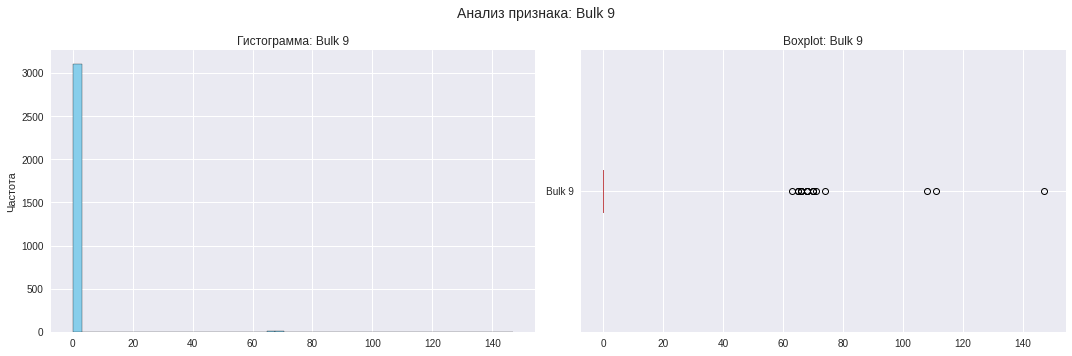

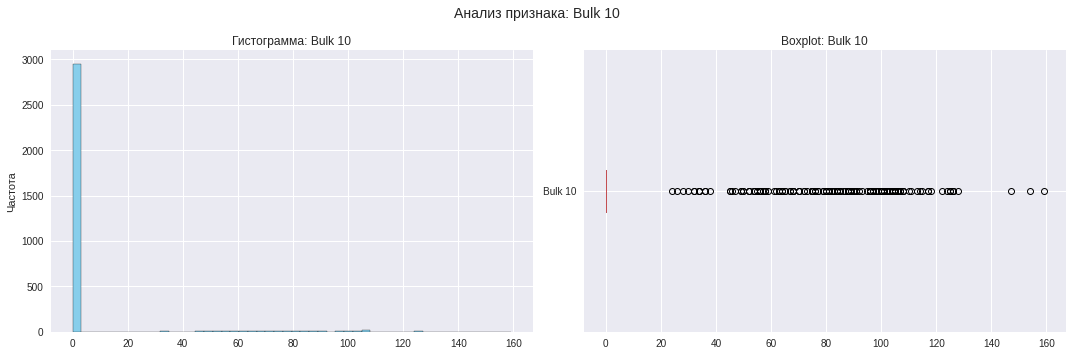

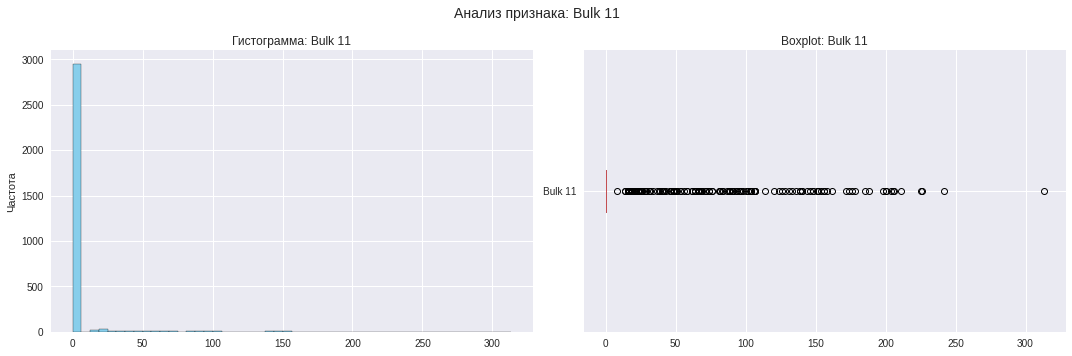

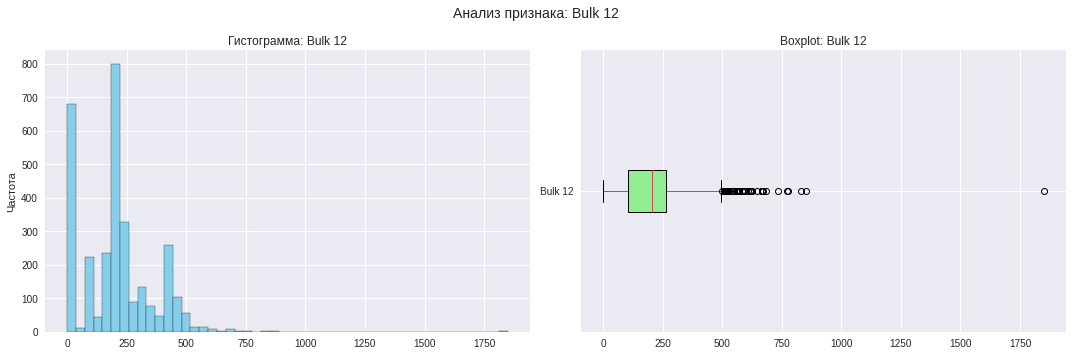

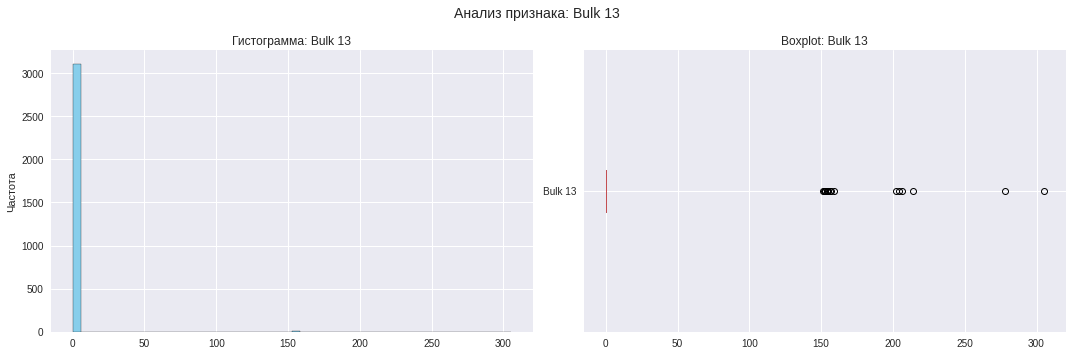

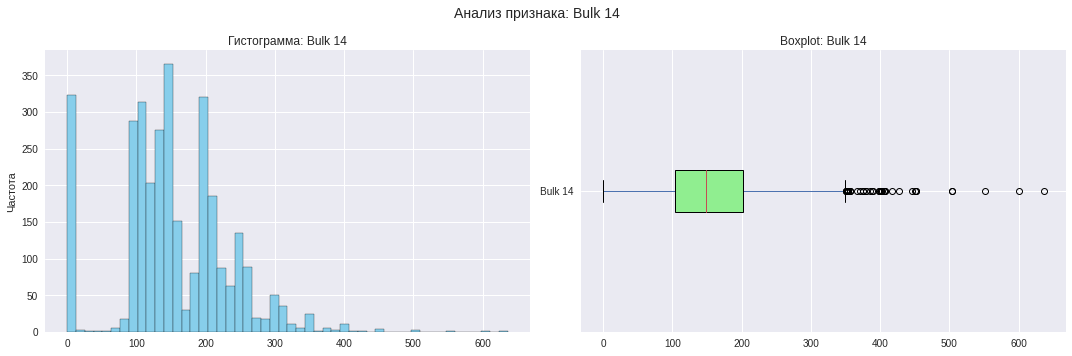

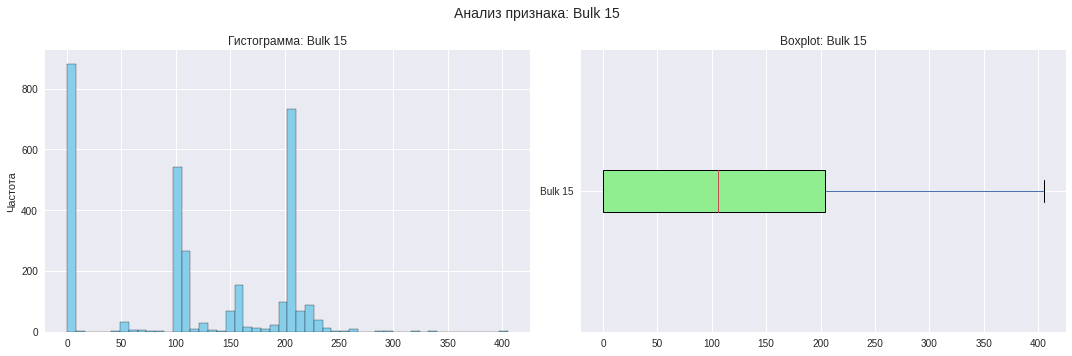

In [62]:
# Настройка стиля графиков
plt.style.use('seaborn')

# Построение графиков для каждого признака
for feature in bulk_features:
    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Анализ признака: {feature}', fontsize=14)
    
    # Гистограмма
    bulk_df[feature].plot(
        kind='hist',
        bins=50,
        ax=ax1,
        title=f'Гистограмма: {feature}',
        legend=False,
        color='skyblue',
        edgecolor='black'
    )
    ax1.set_ylabel("Частота")
    
    # Boxplot
    bulk_df[feature].plot(
        kind='box',
        ax=ax2,
        title=f'Boxplot: {feature}',
        legend=False,
        vert=False,
        patch_artist=True,
        boxprops={'facecolor': 'lightgreen'}
    )
    
    plt.tight_layout()
    plt.show()

Часто было не более 5 этапов добавления материала, в связи с этим в некоторых признаках много нулей. Будет интересно посмотреть на распределение признаков без учета нулей: только те этапы, когда материал добавляли. 

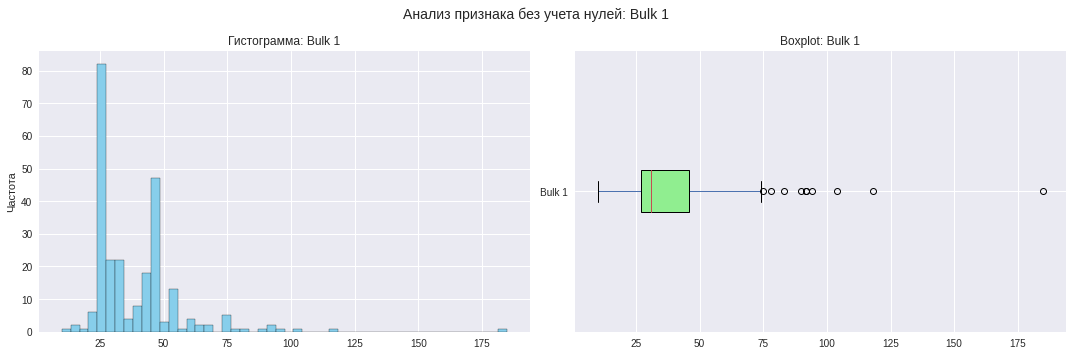

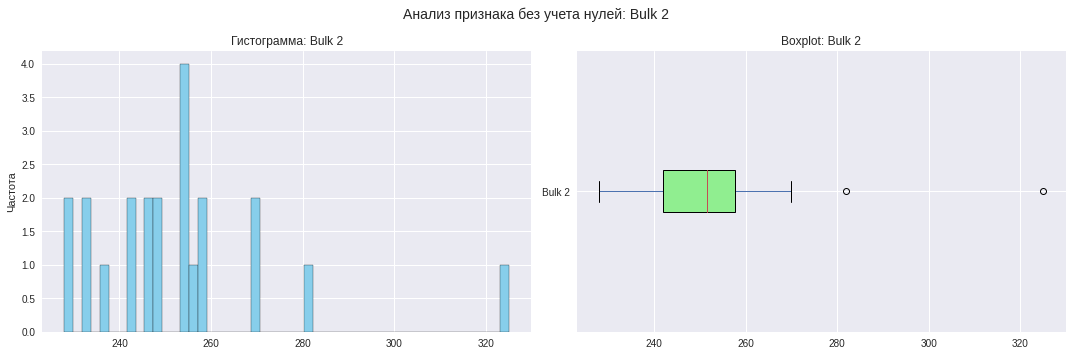

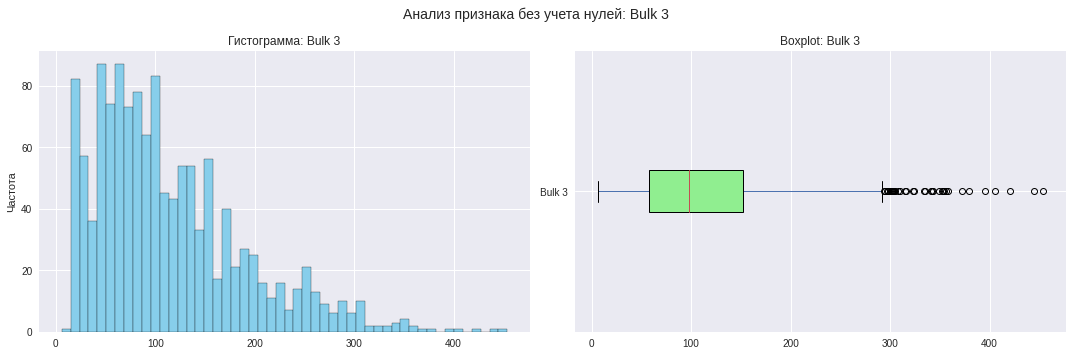

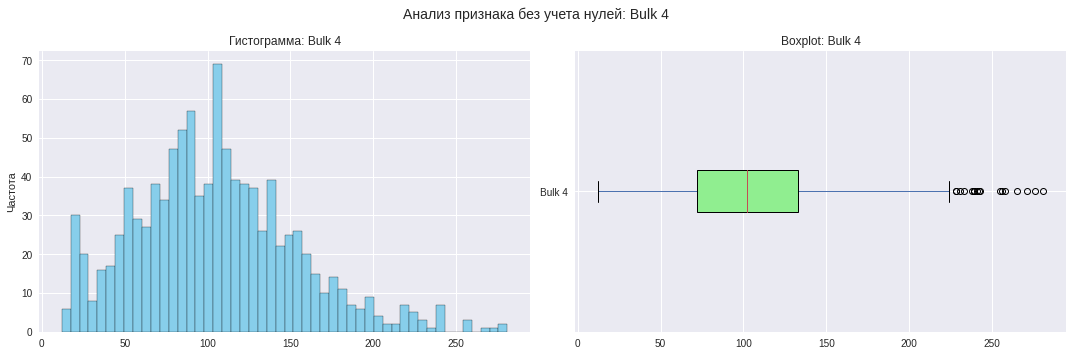

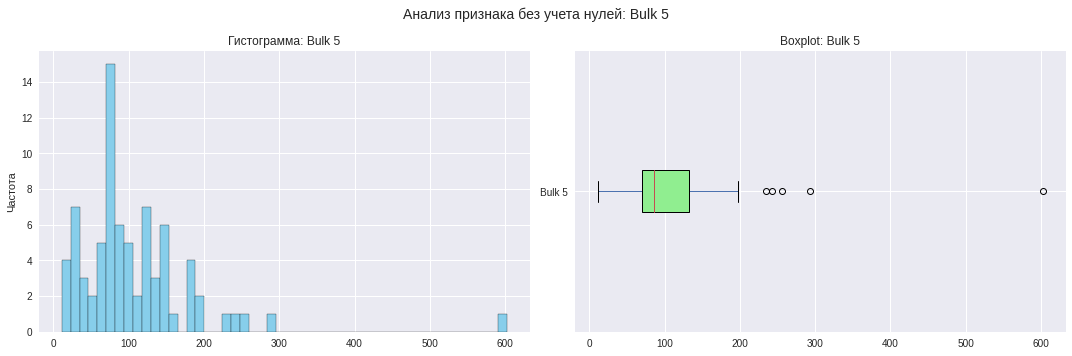

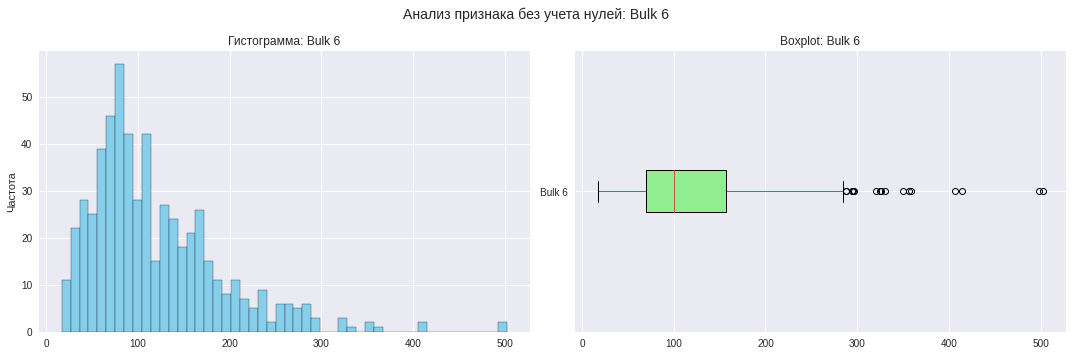

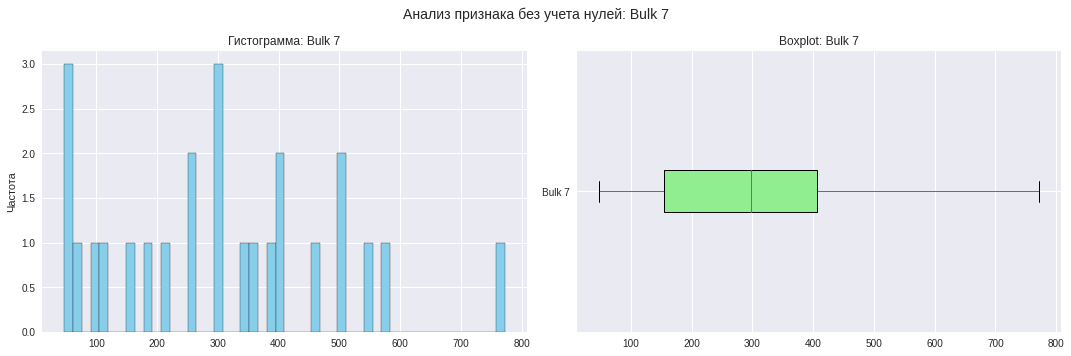

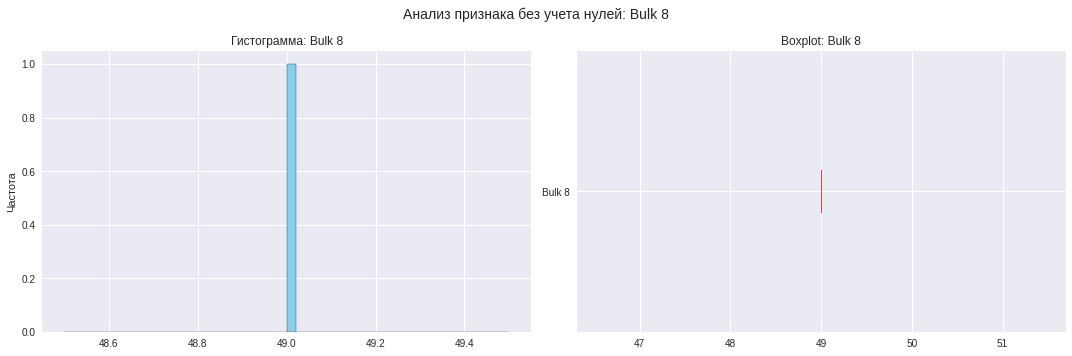

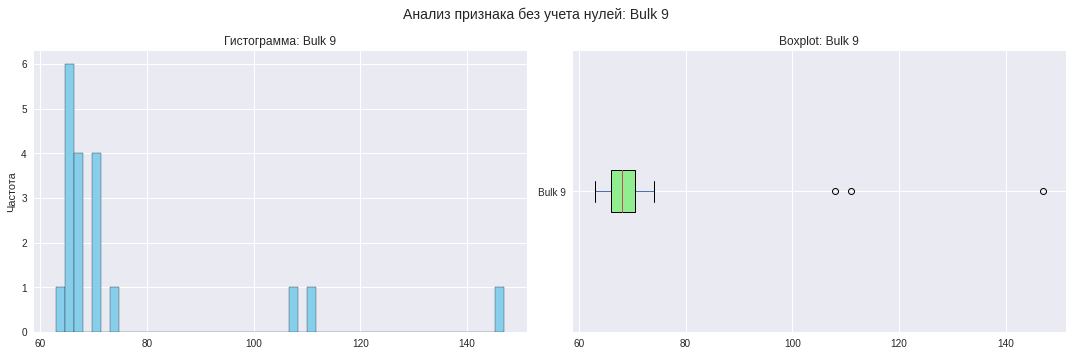

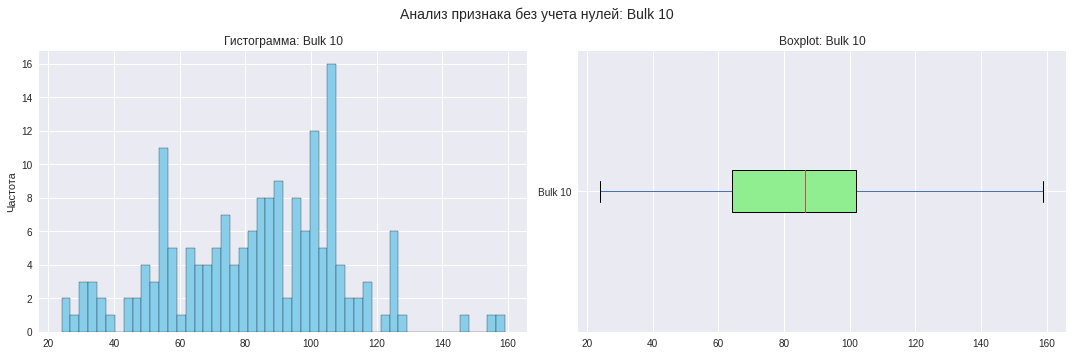

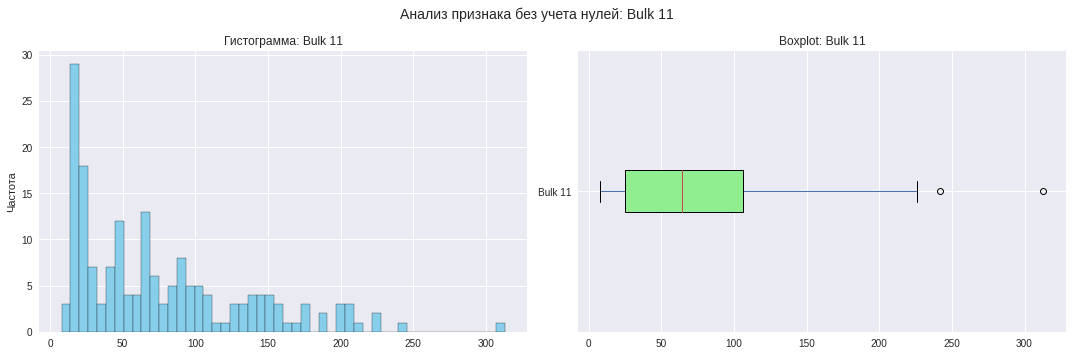

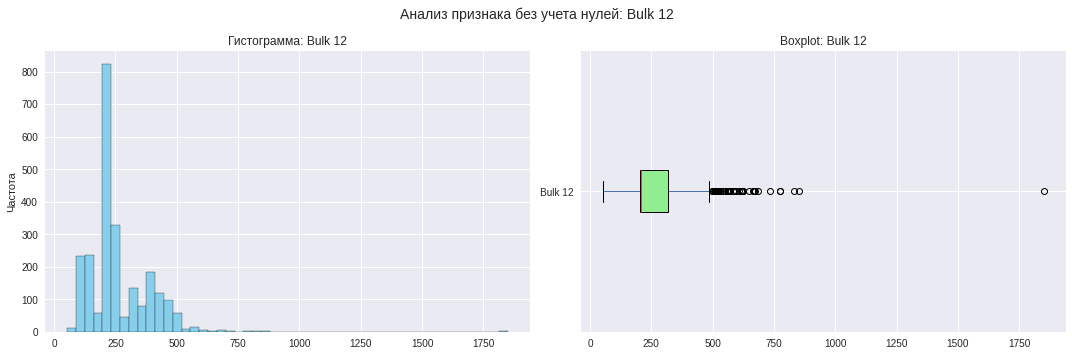

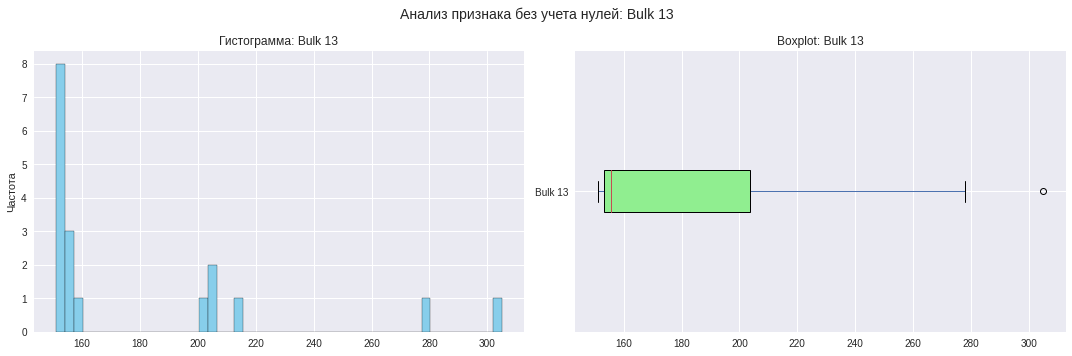

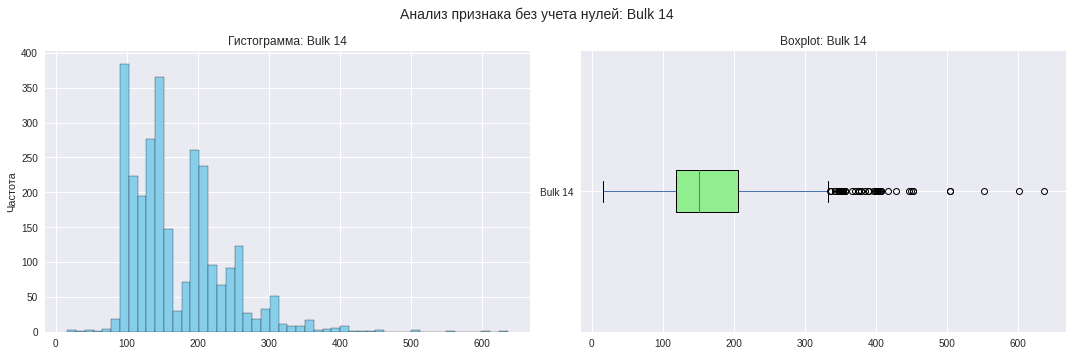

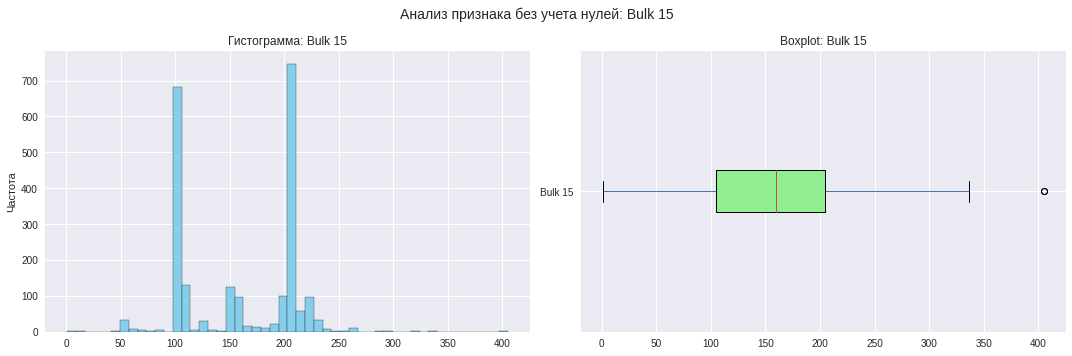

In [63]:
# Построение графиков для каждого признака
for feature in bulk_features:
    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Анализ признака без учета нулей: {feature}', fontsize=14)
    
    # Гистограмма
    bulk_df[bulk_df[feature]>0][feature].plot( #отобрали только ненулевые значения
        kind='hist',
        bins=50,
        ax=ax1,
        title=f'Гистограмма: {feature}',
        legend=False,
        color='skyblue',
        edgecolor='black'
    )
    ax1.set_ylabel("Частота")
    
    # Boxplot
    bulk_df[bulk_df[feature]>0][feature].plot(#отобрали только ненулевые значения
        kind='box',
        ax=ax2,
        title=f'Boxplot: {feature}',
        legend=False,
        vert=False,
        patch_artist=True,
        boxprops={'facecolor': 'lightgreen'}
    )
    
    plt.tight_layout()
    plt.show()

В некоторых признаках очень мало наблюдений, например, в Bulk2, Bulk 7, Bulk 9, Bulk 13. В Bulk 8 всего одно ненулевое наблюдение.<br>
В признаках, где много ненулевых наблюдений, распределение в целом напоминает нормальное, иногда скошенное вправо.<br>
Выбросы есть, но они не являются аномалиями, значения в разумных диапазонах.<br>

Рассчитаем также общее количество добавленного материала.


In [64]:
bulk_df['Bulk_total'] = bulk_df.drop(columns=['key']).sum(axis=1)

In [65]:
bulk_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [66]:
bulk_df.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_total
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271,595.503356
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698,276.557794
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,429.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,591.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,772.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000


В таблице 3129 наблюдений. В среднем количество добавляемого материала за 15 итераций составило 1191 (минимум 38, максимум 6470)

### Исследовательский анализ таблицы data_bulk_time

In [67]:
bulk_time_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [68]:
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице 3129 строк. Содержится 15 признаков - время подачи материалов на каждом этапе.<br>
Заметим, что типы столбцов не соответствуют описанию и данным, поэтому изменим их на datetime.

In [69]:
for feature in bulk_features:
    bulk_time_df[feature] = pd.to_datetime(bulk_time_df[feature])

In [70]:
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [71]:
bulk_time_df['Bulk_time_max'] =bulk_time_df.drop(columns=['key']).max(axis=1, skipna=True)

In [72]:
bulk_time_df['Bulk_time_min'] = bulk_time_df.drop(columns=['key']).min(axis=1, skipna=True)

In [73]:
bulk_time_df['time_delta'] = (bulk_time_df['Bulk_time_max']  - bulk_time_df['Bulk_time_min']).dt.total_seconds() /60

In [74]:
bulk_time_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_time_max,Bulk_time_min,time_delta
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:28:48,2019-05-03 11:10:43,18.083333
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:53:30,2019-05-03 11:36:50,16.666667
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:32:39,2019-05-03 12:16:16,16.383333
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:58:00,2019-05-03 12:43:22,14.633333
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47,3.416667


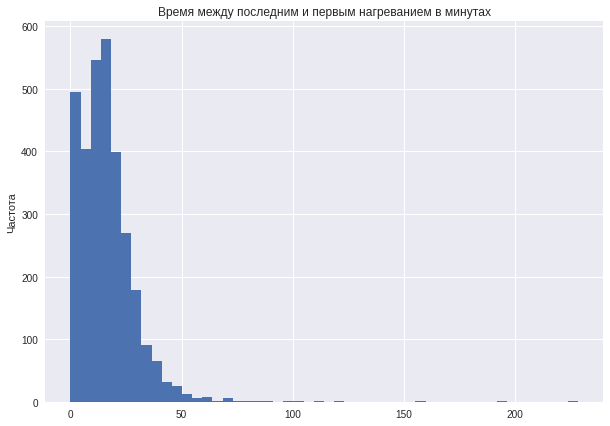

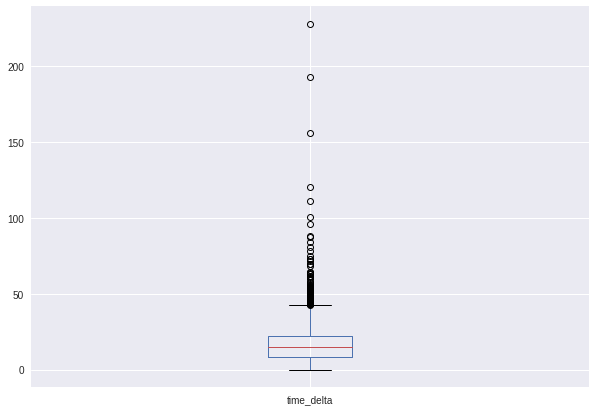

In [75]:
bulk_time_df.plot(y='time_delta',title='Время между последним и первым нагреванием в минутах', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
bulk_time_df.plot(y='time_delta', kind='box' , figsize = (10,7), legend = False);

В основном уходит менее часа на нагревание. Есть выбросы, но тоже укладываются в 4 часа.<br>
В данных много пропусков. Заполним константой '2025-04-21' пропущенные значения.

In [76]:
#bulk_time_df = bulk_time_df.fillna(pd.to_datetime('2025-04-21'))

In [77]:
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            3129 non-null   int64         
 1   Bulk 1         252 non-null    datetime64[ns]
 2   Bulk 2         22 non-null     datetime64[ns]
 3   Bulk 3         1298 non-null   datetime64[ns]
 4   Bulk 4         1014 non-null   datetime64[ns]
 5   Bulk 5         77 non-null     datetime64[ns]
 6   Bulk 6         576 non-null    datetime64[ns]
 7   Bulk 7         25 non-null     datetime64[ns]
 8   Bulk 8         1 non-null      datetime64[ns]
 9   Bulk 9         19 non-null     datetime64[ns]
 10  Bulk 10        176 non-null    datetime64[ns]
 11  Bulk 11        177 non-null    datetime64[ns]
 12  Bulk 12        2450 non-null   datetime64[ns]
 13  Bulk 13        18 non-null     datetime64[ns]
 14  Bulk 14        2806 non-null   datetime64[ns]
 15  Bulk 15        2248 n

### Исследовательский анализ таблицы data_gas

In [78]:
gas_df.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [79]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [80]:
gas_df['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

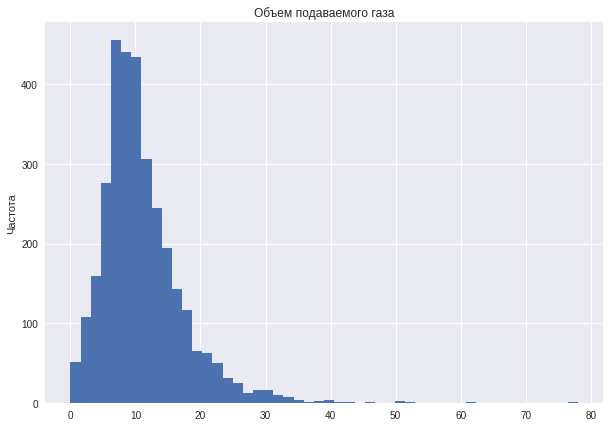

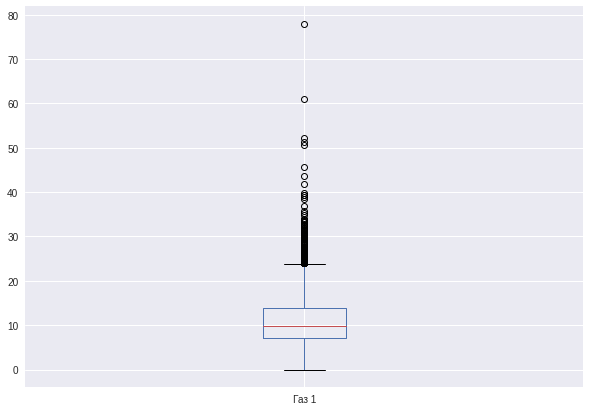

In [81]:
gas_df.plot(y='Газ 1',title='Объем подаваемого газа', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
gas_df.plot(y='Газ 1', kind='box' , figsize = (10,7), legend = False);

In [82]:
# Проверка на дубликаты
gas_df['key'].duplicated().sum()

0

В таблице gas_df, содержащей объем подаваемого газа, содержится 3239 строк, пропусков нет. В основном объем подаваемого газа сотсавляет от 7 до 13.8.

### Исследовательский анализ таблицы data_temp

In [83]:
temp_df.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [84]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


Заменим типы данных: у числового показателя на float, у даты на datetime.

In [85]:
temp_df['Температура'] = temp_df['Температура'].astype('float')

In [86]:
temp_df['Время замера'] = pd.to_datetime(temp_df['Время замера'])

In [87]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [88]:
#Проверка на пропуски в данных
temp_df.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Много пропусков в столбце Температура.

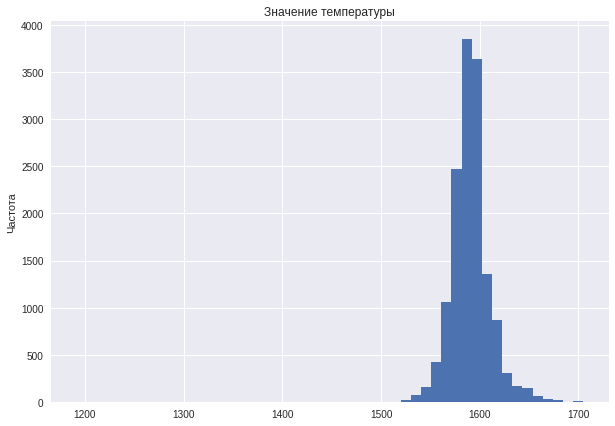

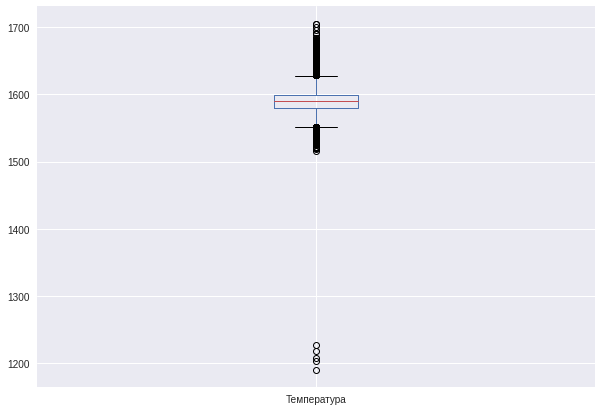

In [89]:
temp_df.plot(y='Температура',title='Значение температуры', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
temp_df.plot(y='Температура', kind='box' , figsize = (10,7), legend = False);

Выявим аномальные значения - значения с температурой менее 1500.

In [90]:
temp_df[temp_df['Температура']<1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Удалим целиком партии с такими значениями.

In [91]:
temp_df = temp_df[~temp_df['key'].isin(temp_df[temp_df['Температура']<1500]['key'])]

In [92]:
temp_df[temp_df['Температура']<1500]

,key,Время замера,Температура


In [93]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18065 non-null  int64         
 1   Время замера  18065 non-null  datetime64[ns]
 2   Температура   14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.5 KB


In [94]:
temp_df['key_count'] = temp_df.groupby('key')['key'].transform('count')

In [95]:
temp_df.head(10)

,key,Время замера,Температура,key_count
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:07:18,1604.0,6
2,1,2019-05-03 11:11:34,1618.0,6
3,1,2019-05-03 11:18:04,1601.0,6
4,1,2019-05-03 11:25:59,1606.0,6
5,1,2019-05-03 11:30:38,1613.0,6
6,2,2019-05-03 11:34:04,1581.0,5
7,2,2019-05-03 11:38:40,1577.0,5
8,2,2019-05-03 11:46:09,1589.0,5
9,2,2019-05-03 11:49:38,1604.0,5


Оставим только те номера партий, где было хотя бы 2 замера: первый и последний.

In [96]:
temp_df = temp_df[~temp_df['key'].isin(temp_df[temp_df['key_count']<2]['key'])]

In [97]:
temp_df[temp_df['key_count']<2]

,key,Время замера,Температура,key_count


In [98]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18063 entries, 0 to 18091
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18063 non-null  int64         
 1   Время замера  18063 non-null  datetime64[ns]
 2   Температура   14641 non-null  float64       
 3   key_count     18063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 705.6 KB


Найдем для каждой партии температуру в начальном и финальном времени замера.

In [99]:
min_temp = temp_df.groupby('key').apply(lambda x: x.loc[x['Время замера'].idxmin(), 'Температура'])
max_temp = temp_df.groupby('key').apply(lambda x: x.loc[x['Время замера'].idxmax(), 'Температура'])

result_temp = pd.DataFrame({
    'temp_at_min_time': min_temp,
    'temp_at_max_time': max_temp
})

In [100]:
result_temp

,temp_at_min_time,temp_at_max_time
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
3237,1569.0,NaN
3238,1584.0,NaN
3239,1598.0,NaN


И удалим строки с пропусками, т.к. для построения модели нас интересуют только те партии, где есть хотя бы 2 замера температуры: начальный и финальный замеры.

In [101]:
result_temp = result_temp.dropna()

In [102]:
result_temp['temp_at_max_time'].isna().sum()

0

In [103]:
result_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp_at_min_time  2471 non-null   float64
 1   temp_at_max_time  2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


Получили таблицу result_temp с номером партии, начальной и финальной температурой. В ней 2471 строк.<br>
Начальную температуру temp_at_min_time можем использовать как входной признак. ФИнальная температура temp_at_max_time - целевой признак. Температуру на промежуточных этапах использовать не можем, это приведет к утечке целевого признака. 

### Исследовательский анализ таблицы data_wire

In [104]:
wire_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [105]:
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


В таблице data_wire, которая содержит объём подаваемых проволочных материалов, 3081 строка. Есть пропуски, которые заполним значением 0, т.к. на данном этапе материал не подавался.

In [106]:
wire_df = wire_df.fillna(0)

In [107]:
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   object 
 3   Wire 3  3081 non-null   object 
 4   Wire 4  3081 non-null   object 
 5   Wire 5  3081 non-null   object 
 6   Wire 6  3081 non-null   object 
 7   Wire 7  3081 non-null   object 
 8   Wire 8  3081 non-null   object 
 9   Wire 9  3081 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [108]:
wire_features = [
    'Wire 1',
    'Wire 2',
    'Wire 3',
    'Wire 4',
    'Wire 5',
    'Wire 6',
    'Wire 7',
    'Wire 8',
    'Wire 9'
]

Изменим у всех показателей тип данных на float.

In [109]:
for feature in wire_features:
    wire_df[feature] = wire_df[feature].astype(float)

In [110]:
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [111]:
wire_df.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Посмотрим на распределение общего объема подаваемого проволочного материала.

In [112]:
wire_df['Wire_total'] = wire_df.drop(columns=['key']).sum(axis=1)

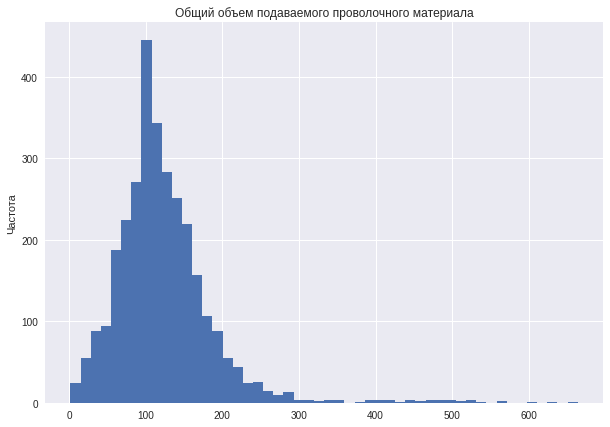

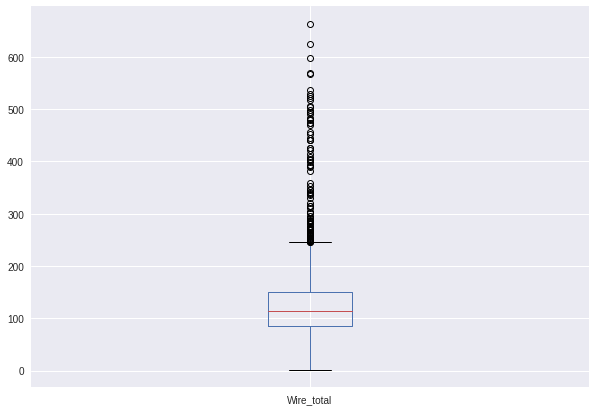

In [113]:
wire_df.plot(y='Wire_total',title='Общий объем подаваемого проволочного материала', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
wire_df.plot(y='Wire_total', kind='box' , figsize = (10,7), legend = False);

### Исследовательский анализ таблицы data_wire_time

In [114]:
wire_time_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [115]:
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице с временем подачи проволочных материалов 3081 строка.<br>
Изменим типы данных на datetime.

In [116]:
for feature in wire_features:
    wire_time_df[feature] = pd.to_datetime(wire_time_df[feature])

In [117]:
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Вычислим время между последней и первой подачей материала, построим график распределения этого признака.

In [118]:
wire_time_df['Wire_time_max'] =wire_time_df.drop(columns=['key']).max(axis=1, skipna=True)

In [119]:
wire_time_df['Wire_time_min'] =wire_time_df.drop(columns=['key']).min(axis=1, skipna=True)

In [120]:
wire_time_df['time_delta'] = (wire_time_df['Wire_time_max']  - wire_time_df['Wire_time_min']).dt.total_seconds() /60

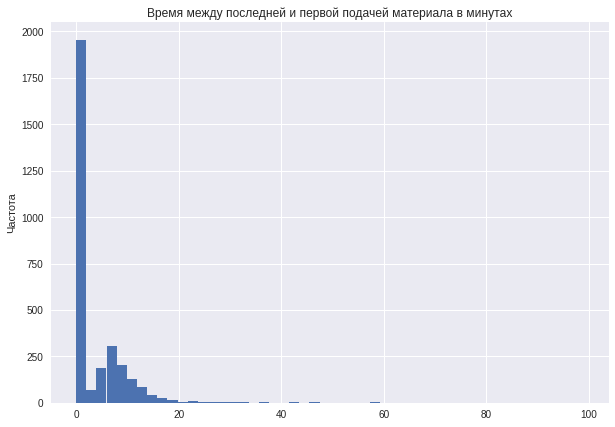

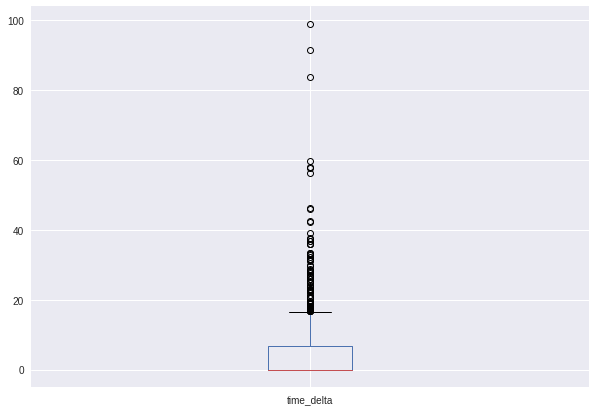

In [121]:
wire_time_df.plot(y='time_delta',title='Время между последней и первой подачей материала в минутах', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
wire_time_df.plot(y='time_delta', kind='box' , figsize = (10,7), legend = False);

In [122]:
#wire_time_df = wire_time_df.fillna(pd.to_datetime('2025-04-21'))

### Объединение таблиц по ключу

In [123]:
result_df = pd.merge(arc_df_total, bulk_df, on='key')

In [124]:
result_df = pd.merge(result_df, bulk_time_df, on='key')

In [125]:
result_df = pd.merge(result_df, gas_df, on='key')

In [126]:
result_df = pd.merge(result_df, result_temp, on='key')

In [127]:
result_df = pd.merge(result_df, wire_df, on='key')

In [128]:
result_df = pd.merge(result_df, wire_time_df, on='key')

In [129]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2325 non-null   int64         
 1   total_active_power     2325 non-null   float64       
 2   total_reactive_power   2325 non-null   float64       
 3   total_heating_time     2325 non-null   float64       
 4   total_power            2325 non-null   float64       
 5   total_active_reactive  2325 non-null   float64       
 6   total_key_count        2325 non-null   int64         
 7   Bulk 1_x               2325 non-null   float64       
 8   Bulk 2_x               2325 non-null   float64       
 9   Bulk 3_x               2325 non-null   float64       
 10  Bulk 4_x               2325 non-null   float64       
 11  Bulk 5_x               2325 non-null   float64       
 12  Bulk 6_x               2325 non-null   float64       
 13  Bul

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


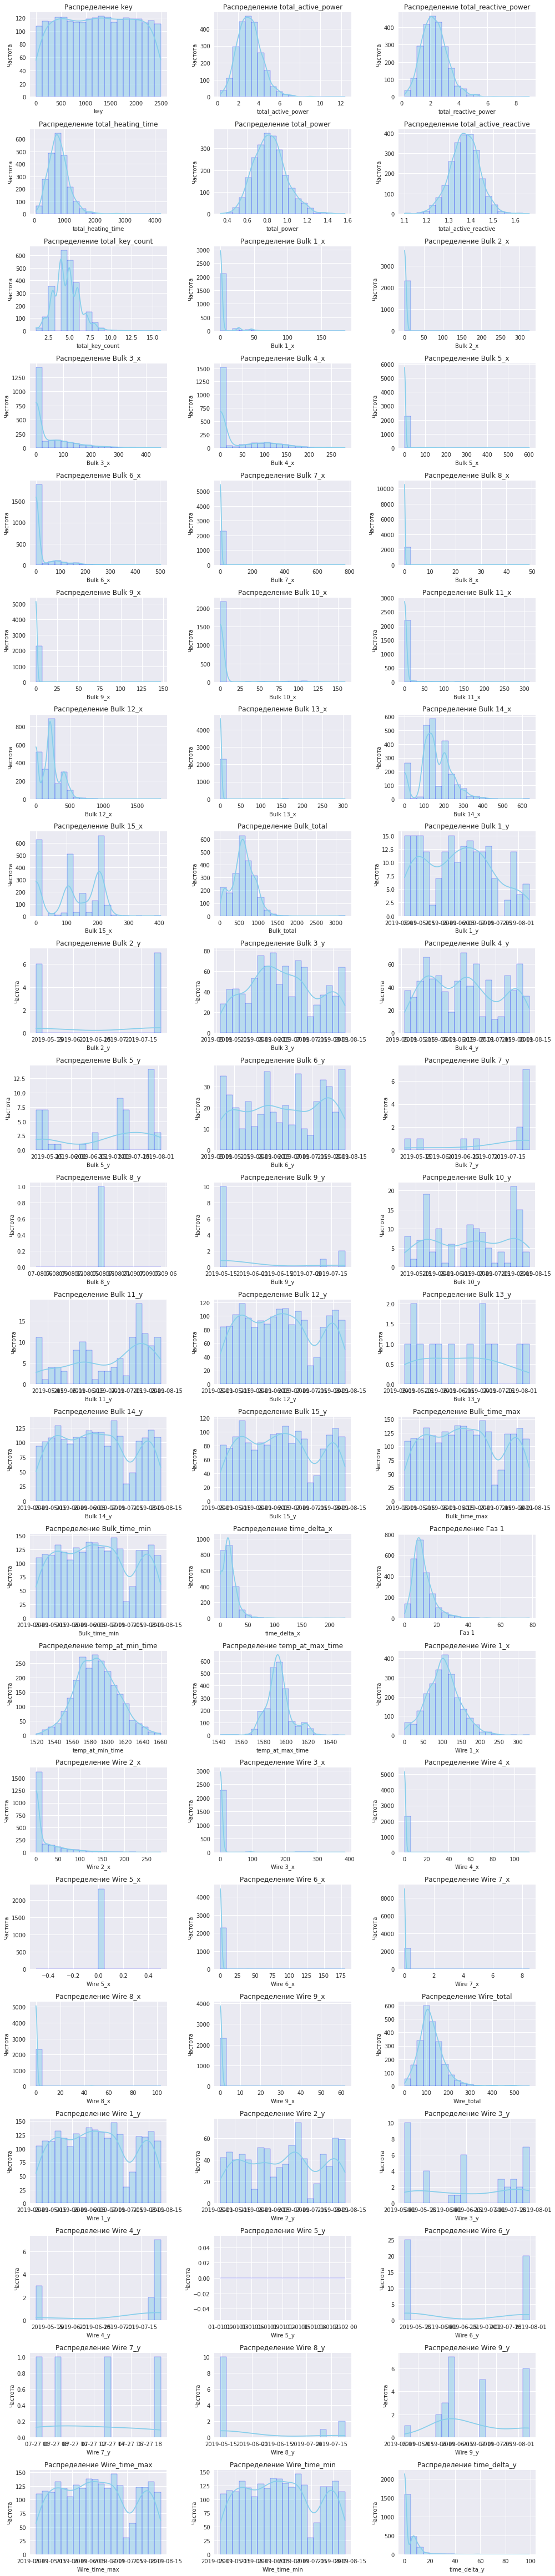

In [130]:
sns.set_style("darkgrid")  # стиль с темной сеткой
plt.figure(figsize=(14, 70))

# Перебираем столбцы и строим гистограммы
for i, column in enumerate(result_df.columns, 1):
    plt.subplot(24, 3, i)  
    sns.histplot(result_df[column], kde=True, bins=20, color='skyblue', edgecolor='blue')
    plt.title(f'Распределение {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Частота', fontsize=10)

plt.tight_layout()
plt.show()

Объединили все финальные обработанные таблицы в одну. Объединение сделали по типу inner join, т.к. во многих таблицах мы уже учли ограничения и устранили аномалии и хотим их в данном виде использовать в качестве данных для задачи.<br>
Получили 2324 строки в таблице и 65 столбцов.<br>
Для каждого признака построили график распределения.

### Корреляционный анализ

Удалим из таблицы созданные вспомогательные признаки 'Bulk_time_max', 'Bulk_time_min', 'Wire_time_max', 'Wire_time_min'.

In [131]:
# Создаем новый DataFrame без колонок 'A' и 'C'
data = result_df.drop(['Bulk_time_max', 'Bulk_time_min', 'Wire_time_max', 'Wire_time_min', 'Wire 1_y', 'key'], axis=1)

In [132]:
interval_cols = data.select_dtypes(include=['number']).columns.tolist()

In [133]:
print(interval_cols)

['total_active_power', 'total_reactive_power', 'total_heating_time', 'total_power', 'total_active_reactive', 'total_key_count', 'Bulk 1_x', 'Bulk 2_x', 'Bulk 3_x', 'Bulk 4_x', 'Bulk 5_x', 'Bulk 6_x', 'Bulk 7_x', 'Bulk 8_x', 'Bulk 9_x', 'Bulk 10_x', 'Bulk 11_x', 'Bulk 12_x', 'Bulk 13_x', 'Bulk 14_x', 'Bulk 15_x', 'Bulk_total', 'time_delta_x', 'Газ 1', 'temp_at_min_time', 'temp_at_max_time', 'Wire 1_x', 'Wire 2_x', 'Wire 3_x', 'Wire 4_x', 'Wire 5_x', 'Wire 6_x', 'Wire 7_x', 'Wire 8_x', 'Wire 9_x', 'Wire_total', 'time_delta_y']


Временные признаки учитывать не будем. В целом можно учесть и их, но их нужно преобразовать в числовые или извлекать из них полезную информацию. Данные об этапах можно получить и из других числовых признаков.

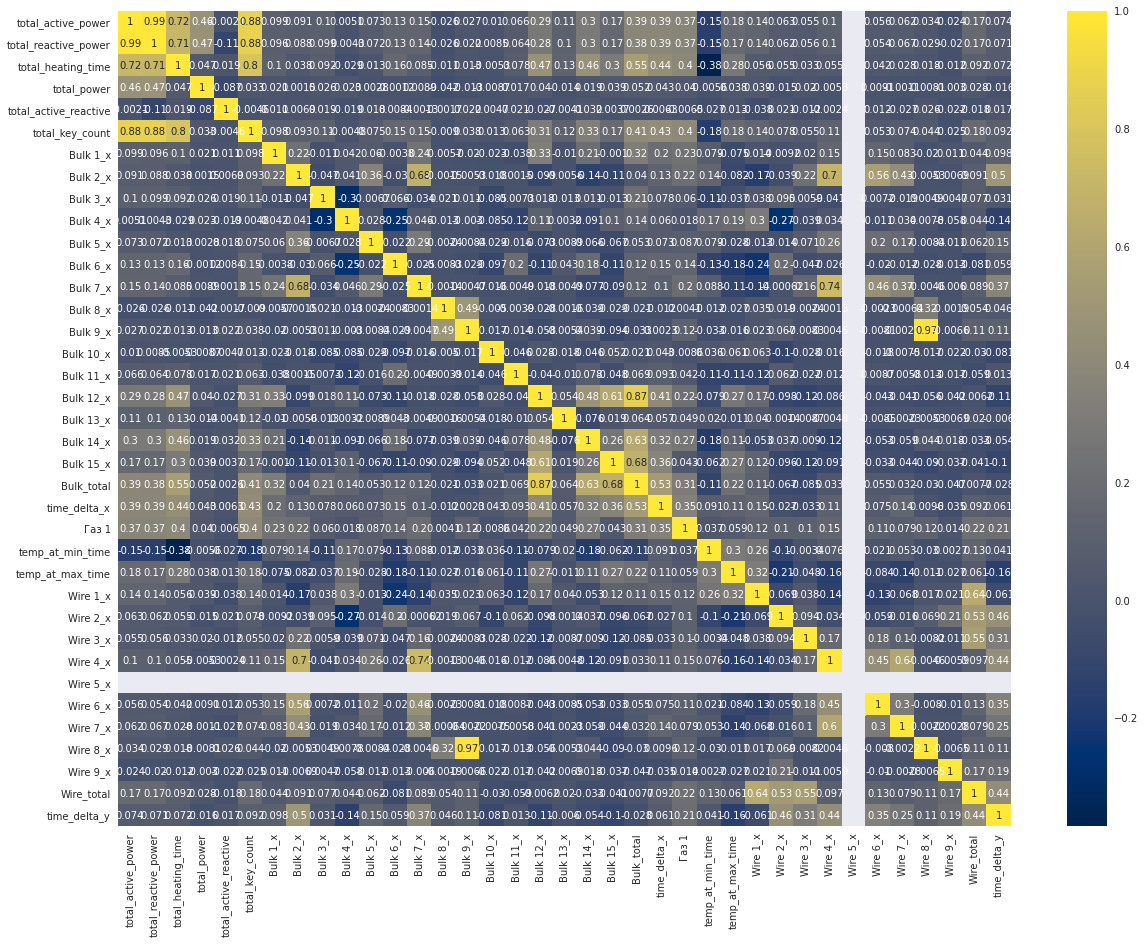

In [134]:
fig, ax = plt.subplots(figsize=(20,15));
sns.heatmap(data[interval_cols].corr(), annot=True, cmap='cividis', ax = ax);


Удалим из данных признак total_reactive_power в связи с сильной корреляцией с total_active_power, а также показатель Wire 8_x.  Проверим, что больше мультиколлинеарности нет.

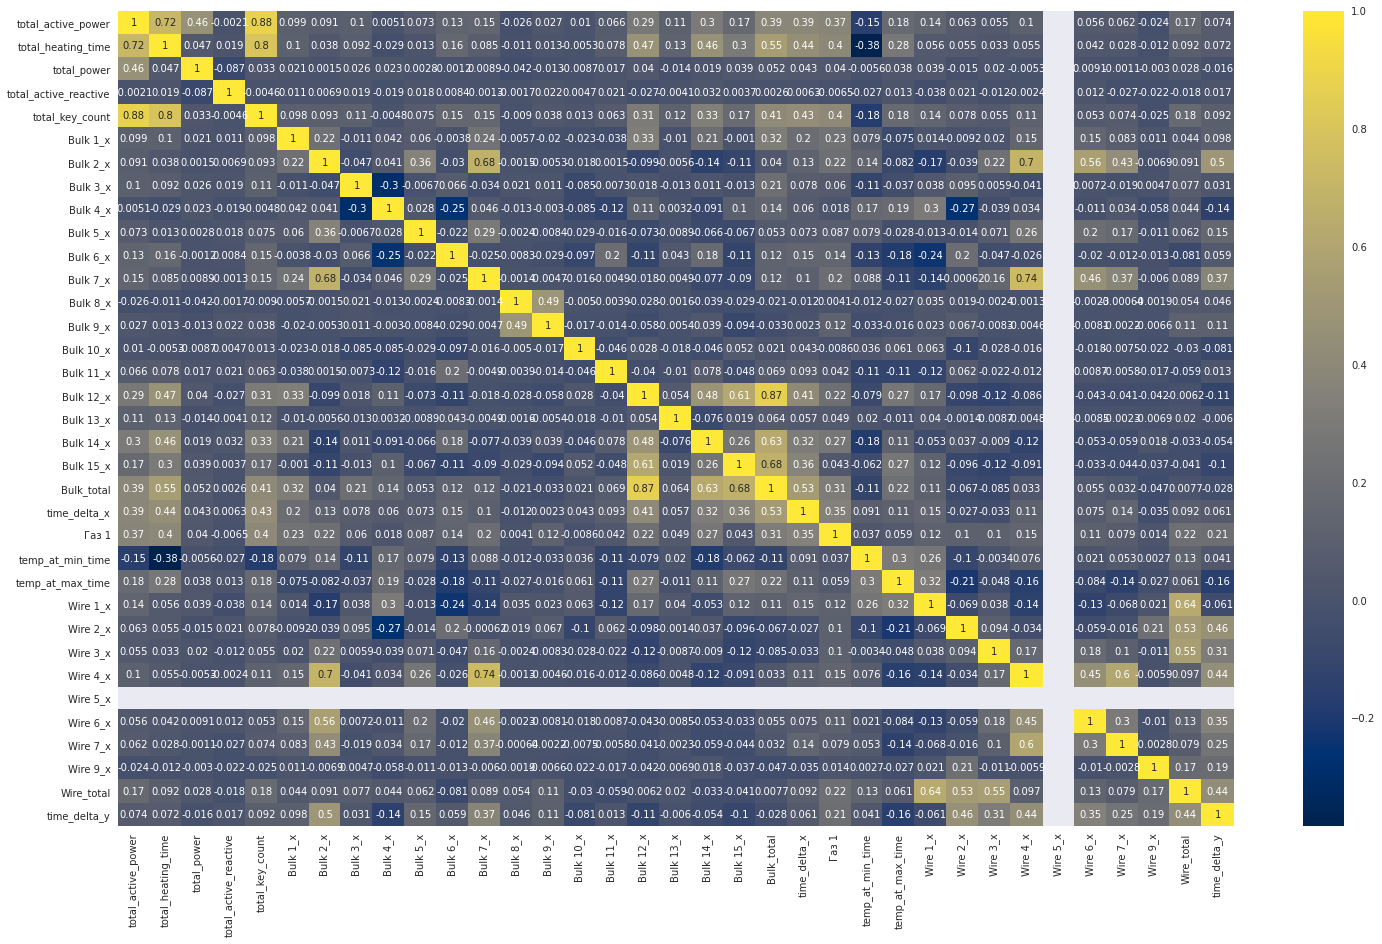

In [135]:
data = data.drop(['total_reactive_power', 'Wire 8_x'], axis=1)
interval_cols = data.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize=(25,15));
sns.heatmap(data[interval_cols].corr(), annot=True, cmap='cividis', ax = ax);


Убрали из данных сильно коррелирующие признаки.<br>
Видна зависимость температуры стали от объемов подаваемого материала, также от показателя temp_at_min_time (Начальная температура), от объемов подаваемых проволочных материалов.

### Подготовка обучающей и тестовой выборки

Разделим данные на тренировочную и тестовую выборки (test_size = 0.25)

In [136]:
RANDOM_STATE = 210425
TEST_SIZE = 0.25

In [137]:
num_columns = [x for x in interval_cols if x != 'temp_at_max_time']
datetime_columns = data.select_dtypes(include=['datetime64']).columns.tolist()
datetime_columns = []

In [138]:
print(num_columns)

['total_active_power', 'total_heating_time', 'total_power', 'total_active_reactive', 'total_key_count', 'Bulk 1_x', 'Bulk 2_x', 'Bulk 3_x', 'Bulk 4_x', 'Bulk 5_x', 'Bulk 6_x', 'Bulk 7_x', 'Bulk 8_x', 'Bulk 9_x', 'Bulk 10_x', 'Bulk 11_x', 'Bulk 12_x', 'Bulk 13_x', 'Bulk 14_x', 'Bulk 15_x', 'Bulk_total', 'time_delta_x', 'Газ 1', 'temp_at_min_time', 'Wire 1_x', 'Wire 2_x', 'Wire 3_x', 'Wire 4_x', 'Wire 5_x', 'Wire 6_x', 'Wire 7_x', 'Wire 9_x', 'Wire_total', 'time_delta_y']


In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    data[num_columns],
    data['temp_at_max_time'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((1743, 34), (582, 34))

In [140]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1743 entries, 1236 to 686
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_active_power     1743 non-null   float64
 1   total_heating_time     1743 non-null   float64
 2   total_power            1743 non-null   float64
 3   total_active_reactive  1743 non-null   float64
 4   total_key_count        1743 non-null   int64  
 5   Bulk 1_x               1743 non-null   float64
 6   Bulk 2_x               1743 non-null   float64
 7   Bulk 3_x               1743 non-null   float64
 8   Bulk 4_x               1743 non-null   float64
 9   Bulk 5_x               1743 non-null   float64
 10  Bulk 6_x               1743 non-null   float64
 11  Bulk 7_x               1743 non-null   float64
 12  Bulk 8_x               1743 non-null   float64
 13  Bulk 9_x               1743 non-null   float64
 14  Bulk 10_x              1743 non-null   float64
 15  Bu

## Обучение модели

In [141]:
def create_keras_model(optimizer='adam', learning_rate=0.001, units=64):
    model = Sequential([
        Dense(units, activation='relu', input_dim=X_train.shape[1]),
        Dense(units//2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mae')
    return model


In [142]:
# Общий препроцессинг
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('datetime', 'passthrough', datetime_columns)
    ],
    remainder='passthrough'
)

# Метрика MAE (чем меньше, тем лучше)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

models = {
    "LinearRegression": {
        "pipe": Pipeline([
            ('preprocessor', data_preprocessor),
            ('model', LinearRegression())
        ]),
        "params": {
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    "DecisionTree": {
        "pipe": Pipeline([
            ('preprocessor', data_preprocessor),
            ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
        ]),
        "params": {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 10, 20],
            'model__min_samples_leaf': [1, 5, 10],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    #"LightGBM": {
    #    "pipe": Pipeline([
    #        ('preprocessor', data_preprocessor),
    #        ('model', lgb.LGBMRegressor(random_state=RANDOM_STATE))
    #    ]),
    #    "params": {
    #        'model__num_leaves': [31, 50],
    #        'model__learning_rate': [0.05, 0.1],
    #        'model__n_estimators': [100, 200],
    #        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    #    }
    #},
    "CatBoost": {
        "pipe": Pipeline([
            ('preprocessor', data_preprocessor),
            ('model', cb.CatBoostRegressor(random_state=RANDOM_STATE, silent=True))
        ]),
        "params": {
            'model__depth': [3, 5, 7],
            'model__learning_rate': [0.05, 0.1],
            'model__iterations': [100, 200],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    "GradientBoosting": {
        "pipe": Pipeline([
            ('preprocessor', data_preprocessor),
            ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
        ]),
        "params": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    "Keras": {
        "pipe": Pipeline([
            ('preprocessor', data_preprocessor),
            ('model', KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0))
        ]),
        "params": {
            'model__units': [64, 128],
            'model__learning_rate': [0.001, 0.01],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        }
    }
}

results = []

for model_name, config in models.items():
    print(f"Training {model_name}...")
    
    search = RandomizedSearchCV(
        config["pipe"],
        config["params"],
        cv=5,
        scoring=mae_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_iter=8
    )
    
    search.fit(X_train, y_train)
    
    results.append({
        "Model": model_name,
        "Best Params": search.best_params_,
        "Best MAE": -search.best_score_,  # Т.к. greater_is_better=False
        "SearchCV": search  # Сохраняем весь поисковый объект
    })
    
# Создаём DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Best MAE")

Training LinearRegression...


/tmp/ipykernel_168/2148075674.py:74: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('model', KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0))
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=8. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training DecisionTree...
Training CatBoost...
Training GradientBoosting...
Training Keras...


2025-05-01 09:07:42.521344: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [143]:
pd.set_option('display.max_colwidth', None)
results_df[['Model', 'Best Params', 'Best MAE']]

,Model,Best Params,Best MAE
2,CatBoost,"{'preprocessor__num': StandardScaler(), 'model__learning_rate': 0.1, 'model__iterations': 200, 'model__depth': 5}",6.170026
3,GradientBoosting,"{'preprocessor__num': MinMaxScaler(), 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.1}",6.230796
0,LinearRegression,{'preprocessor__num': MinMaxScaler()},6.861388
1,DecisionTree,"{'preprocessor__num': MinMaxScaler(), 'model__min_samples_split': 20, 'model__min_samples_leaf': 10, 'model__max_depth': 30}",7.499589
4,Keras,"{'preprocessor__num': MinMaxScaler(), 'model__units': 128, 'model__learning_rate': 0.01}",9.241785


Для построения прогноза были применены несколько моделей:<br>
    - LinearRegression<br>
    - DecisionTreeRegressor<br>
    - KerasRegressor<br>
    - CatBoostRegressor<br>
    - GradientBoostingRegressor<br>
Они оценивались метрикой качества MAE.<br>
Лучше всего метрику дала модель бустинга **CatBoostRegressor** со следующими параметрами:<br>
    - iterations: 200<br>
    - depth: 5<br>
    - learning_rate: 0.1<br>
    - метод масштабирования StandardScaler()<br>
Значение метрики MAE составило 6.16<br>


## Тестирование модели

### Анализ важности признаков

In [144]:
feature_names = num_columns + datetime_columns

In [145]:
data_preprocessor.fit(X_train, y_train)
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns = feature_names)
# выводим предсказанные значения тренировочной выборки
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns = feature_names)

In [146]:
best_search = results_df.iloc[0]['SearchCV']

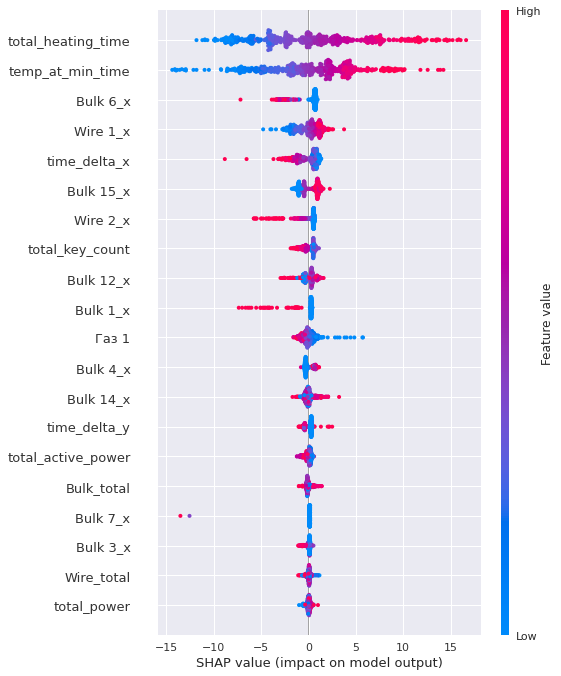

In [147]:
explainer = shap.Explainer(best_search.best_estimator_.named_steps['model'], X_test_p)
shap_values = explainer(X_test_p)

# Use a different plot type that doesn't rely on the problematic function
shap.summary_plot(shap_values, X_test_p, show=False)

С ростом общего времени нагревания, а также начальной температуры растет и финальная температура стали.

### Расчет на тестовой выборке

In [148]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = best_search.predict(X_test)

print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, pred)}')
print(f'Метрика R2 на тестовой выборке: {r2_score(y_test, pred)}')

Метрика MAE на тестовой выборке: 5.850216321300761
Метрика R2 на тестовой выборке: 0.47929858394808655


Сравним с константной моделью

In [149]:
pred_median = np.ones(len(X_test)) *y_train.median()
print("Метрика MAE константной модели:", mean_absolute_error(y_test, pred_median) )
print("Метрика R2 константной модели:", r2_score(y_test, pred_median) )

Метрика MAE константной модели: 7.922680412371134
Метрика R2 константной модели: -0.0026097541528817825


Модель **CatBoostRegressor** на тестовой выборке дает следующие значения метрики:
- **MAE: 5.85**
- **R2: 0.48** <br>
Тогда как **константная модель** (предсказания одним значением  - медианой тренировочной выборки) дает метрики:
- **MAE: 7.92**
- **R2 : -0.002**<br>
Таким образом CatBoostRegressor предсказывает значительно лучше, чем константная модель, и удовлетворяет условиям задачи, но значение R2 далеко от единицы.

### Зависимость конечной температуры сплава от начальной температуры

На графике корреляции и при исследовании анализов важности признаков модели видели, что целевой признак растет с ростом начальной температуры сплава.<br>
Построим график и рассмотрим зависимость подробнее.

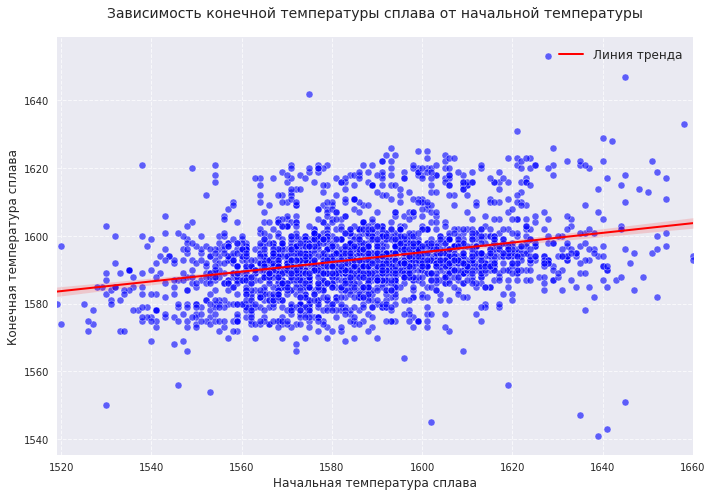

In [150]:
# Создаем фигуру
plt.figure(figsize=(10, 7))

# Точечный график
sns.scatterplot(data=data, x='temp_at_min_time', y='temp_at_max_time', 
                alpha=0.6, color='blue')

# Линия тренда (линейная регрессия)
sns.regplot(data=data, x='temp_at_min_time', y='temp_at_max_time', 
            scatter=False, color='red', line_kws={'linewidth': 2}, 
            label='Линия тренда')

# Настройки графика
plt.title('Зависимость конечной температуры сплава от начальной температуры', fontsize=14, pad=20)
plt.xlabel('Начальная температура сплава', fontsize=12)
plt.ylabel('Конечная температура сплава', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Легенда
plt.legend(fontsize=12)

# Улучшаем отображение
plt.tight_layout()
plt.show()

In [151]:
y_test

1093    1580.0
1043    1589.0
753     1600.0
872     1583.0
1030    1600.0
         ...  
1144    1597.0
1136    1591.0
2112    1599.0
1027    1602.0
2001    1576.0
Name: temp_at_max_time, Length: 582, dtype: float64

In [152]:
test_preds = pd.Series(pred.tolist(), index = y_test.index)

In [153]:
data_pred = pd.DataFrame(y_test)

In [154]:
data_pred['pred'] = test_preds

In [155]:
data_pred.index

Int64Index([1093, 1043,  753,  872, 1030, 1428, 1213, 1954, 1418, 1517,
            ...
            1717,  524,  439, 1426,  573, 1144, 1136, 2112, 1027, 2001],
           dtype='int64', length=582)

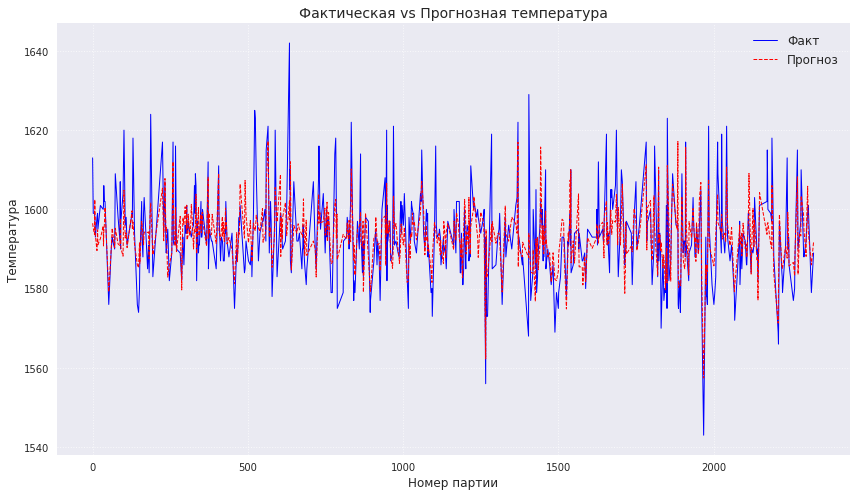

In [156]:
plt.figure(figsize=(12, 7))

# Сортируем данные
data_sorted = data_pred.sort_index()

# Основные линии
plt.plot(data_sorted['temp_at_max_time'], 
         'b-', linewidth=1,  label='Факт')
plt.plot(data_sorted['pred'], 
         'r--', linewidth=1, label='Прогноз')

# Оформление
plt.title('Фактическая vs Прогнозная температура', fontsize=14)
plt.xlabel('Номер партии', fontsize=12)
plt.ylabel('Температура', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=1)

plt.tight_layout()
plt.show()

## Выводы

### Общий анализ данных:<br>
Были изучены данные о партиях стали.<br>
Несколько таблиц содеражт данные:  об электродах, об объёме и времени подачи сыпучих материалов, о продувке сплава газом, об измерениях температуры, об объёме и времени подачи проволочных материалов.<br>
Целью исследования было:<br>
построить модель, которая будет предсказывать температуру сплава для имитации технологического процесса и в дальнейшем уменьшения электропотребления на этапе обработки стали. <br>
Заказчиком выступил металлургический комбинат «Стальная птица».


### Предобработка данных:
Были проанализированы 7 таблицы из БД, в них заполнены пропуски, исправлены типы данных, удалены аномалии.<br>
Были добавлены новые признаки Общая активная мощность, Общая реактивная мощность, Общее время нагревания дугой, Соотношение активной и реактивной мощности. Показатели были агрегированы по номеру партии стали.<br>
Были выделены признаки: начальная температура стали и целевой признак - финальная температура стали.<br>
Далее таблицы были объединены в одну. Всего получилось 2325 строки и 65 признаков.


### Обучение:
Подготовили набор данных на основе первичного и корреляционного анализа. Отобрали факторы. <br>

Для построения прогноза были применены несколько моделей:<br>
    - LinearRegression<br>
    - DecisionTreeRegressor<br>
    - KerasRegressor<br>
    - CatBoostRegressor<br>
    - GradientBoostingRegressor<br>
Они оценивались метрикой качества MAE.<br>
Лучше всего метрику дала модель бустинга **CatBoostRegressor** со следующими параметрами:<br>
    - iterations: 200<br>
    - depth: 5<br>
    - learning_rate: 0.1<br>
    - метод масштабирования StandardScaler()<br>
Значение метрики MAE составило 6.16<br>


### Тестирование
Модель **CatBoostRegressor** на тестовой выборке дает следующие значения метрики:
- **MAE: 5.85**
- **R2: 0.48** <br>
Тогда как **константная модель** (предсказания одним значением  - медианой тренировочной выборки) дает метрики:
- **MAE: 7.92**
- **R2 : -0.002**<br>
Таким образом CatBoostRegressor предсказывает значительно лучше, чем константная модель, и удовлетворяет условиям задачи, но значение R2 далеко от единицы.


### Анализ важности признаков:
Исследовали важность признаков. С ростом общего времени нагревания, а также начальной температуры растет и финальная температура стали.<br>
Проанализировали зависимость целевого признака от начальной температуры сплава.
  
### Выводы:
Модель CatBoostRegressor показала лучший результат (MAE = 5.85, R² = 0.48) по сравнению с константной моделью (MAE = 7.92, R² ≈ 0).Это означает, что модель действительно улавливает некоторые зависимости, но её точность пока недостаточно высока для полного доверия.<br>

*Наибольшее влияние на температуру оказывают*:<br>
Начальная температура сплава<br>
Общее время нагревания дугой<br>
Это согласуется с физикой процесса: чем дольше и мощнее нагрев, тем выше итоговая температура.

*Ограничения модели:*<br>
R² = 0.48 говорит о том, что модель объясняет лишь ~48% дисперсии данных.<br>
Возможно, не учтены важные скрытые факторы (например, состав стали, состояние оборудования, внешние условия).

*Улучшения модели:*<br>
можно использовать гибридные подходы:<br>
Комбинация CatBoost + нейросеть (например, TabTransformer).
Ансамбли с LGBM и XGBoost.<br>

*Рекомендации для заказчика:*<br>
Использовать модель для предварительного прогноза температуры с ручной проверкой критичных партий.<br>
Снизить энергозатраты, оптимизируя время нагрева на основе предсказаний.<br>
Внедрить A/B-тестирование (одни партии – с ML-управлением, другие – по старой схеме).<br>
Измерять не только температуру, но и экономию энергии.